# Подключение библиотек

In [3]:
import os
import random
import copy
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, matthews_corrcoef)

# Задаём RandomSeed
SEED = 52
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Устройство для вычислений
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Импорт данных

In [5]:
# Определяем типы заболеваний
disease_types = ['COVID', 'non-COVID']

# Указываем директорию с данными
data_dir = '../input/sarscov2-ctscan-dataset/'

# Определяем директорию для тренировочных данных
train_dir = os.path.join(data_dir)

# Создаем пустой список для хранения информации о тренировочных данных
train_data = []

# Проходим по каждому типу заболевания и собираем информацию о файлах
for defects_id, sp in enumerate(disease_types):
    # Для каждого файла в поддиректории, соответствующей типу заболевания
    for file in os.listdir(os.path.join(train_dir, sp)):
        # Добавляем информацию о файле в список: путь к файлу, ID заболевания, тип заболевания
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

# Преобразуем собранные данные в DataFrame
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])

# Перемешиваем строки DataFrame случайным образом
# frac=1 означает, что берется 100% данных, random_state=SEED задает начальное значение для генератора случайных чисел для воспроизводимости
train = train.sample(frac=1, random_state=SEED)

# Сбрасываем индексы DataFrame, чтобы они шли по порядку после перемешивания
train.index = np.arange(len(train))

# Выводим первые несколько строк DataFrame для проверки
train.head()

File  DiseaseID Disease Type
0   non-COVID/Non-Covid (627).png          1    non-COVID
1  non-COVID/Non-Covid (1015).png          1    non-COVID
2   non-COVID/Non-Covid (985).png          1    non-COVID
3           COVID/Covid (687).png          0        COVID
4   non-COVID/Non-Covid (543).png          1    non-COVID

In [6]:
# Пути к данным и меткам
data_dir = '/kaggle/input/sarscov2-ctscan-dataset/'
image_paths = [os.path.join(data_dir, file) for file in train['File'].values]
labels = train['DiseaseID'].values

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=SEED, shuffle=True)

# Определение трансформаций
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Определение пользовательского датасета
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Создаем датасеты и DataLoader
train_dataset = CustomDataset(X_train, y_train, image_transforms)
test_dataset = CustomDataset(X_test, y_test, image_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Проверяем содержимое DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break  # Выводим только первую batch для проверки

torch.Size([32, 1, 224, 224]) torch.Size([32])


In [7]:
# Вывод количества примеров в тренировочном и валидационном наборах данных
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

print(f"Размер тренировочного набора данных: {train_size}")
print(f"Размер валидационного набора данных: {val_size}")

Размер тренировочного набора данных: 1984
Размер валидационного набора данных: 497


In [8]:
train_batch_size = train_loader.batch_size
val_batch_size = val_loader.batch_size

print(f"Размер батча в тренировочном наборе данных: {train_batch_size}")
print(f"Размер батча в валидационном наборе данных: {val_batch_size}")

Размер батча в тренировочном наборе данных: 32
Размер батча в валидационном наборе данных: 32


# Нарезка изображения

1 28 28 8 8


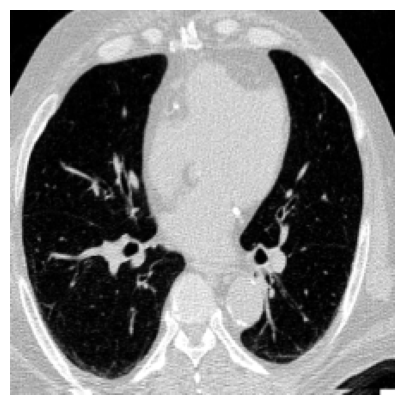

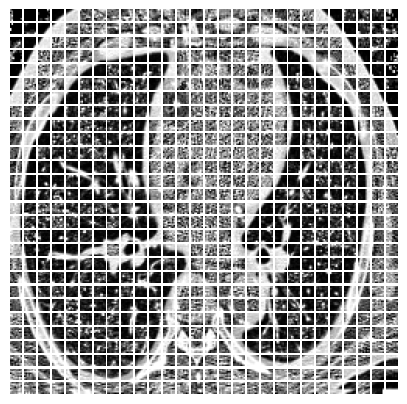

In [9]:
# Установка гиперпараметров и проверка совместимости img_size и patch_size
img_size = 224
patch_size = (8, 8)
embedding_dim = 32

def make_patches(images, patch_size):
    batch_size, channels, height, width = images.shape
    ph, pw = patch_size
    
    # Вычисляем количество патчей по высоте и ширине
    nh = height // ph
    nw = width // pw
    
    # Разбиваем изображение на патчи
    patches = images.unfold(2, ph, ph).unfold(3, pw, pw)
    patches = patches.contiguous().view(batch_size, channels, nh, nw, ph, pw)
    
    return patches


# Получаем изображение из датасета
img = train_dataset[0][0]  # Черно-белое изображение имеет форму (1, H, W)

# Создаем патчи
batch_patches = make_patches(img.unsqueeze(0), patch_size)

# Извлекаем патчи
patches = batch_patches[0]  # Формат (C, NH, NW, PH, PW)
c, nh, nw, ph, pw = patches.shape
print(c, nh, nw, ph, pw)

# Отображаем оригинальное изображение
plt.figure(figsize=(5, 5))
plt.imshow(img[0], cmap='gray')
plt.axis("off")
plt.show()

# Отображаем патчи
plt.figure(figsize=(5, 5))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[0, i, j], cmap='gray')
        plt.axis("off")

plt.show()

1 7 7 32 32


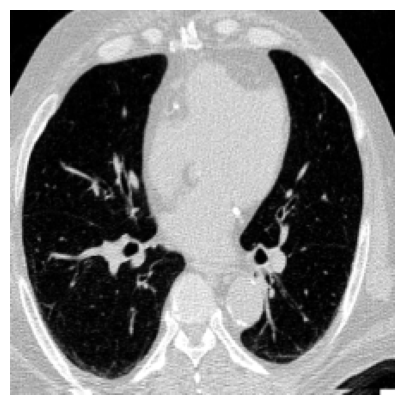

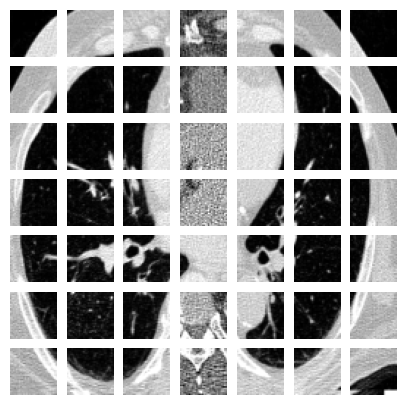

In [10]:
patch_size = (32, 32)

# Создаем патчи
batch_patches = make_patches(img.unsqueeze(0), patch_size)

# Извлекаем патчи
patches = batch_patches[0]  # Формат (C, NH, NW, PH, PW)
c, nh, nw, ph, pw = patches.shape
print(c, nh, nw, ph, pw)

# Отображаем оригинальное изображение
plt.figure(figsize=(5, 5))
plt.imshow(img[0], cmap='gray')
plt.axis("off")
plt.show()

# Отображаем патчи
plt.figure(figsize=(5, 5))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[0, i, j], cmap='gray')
        plt.axis("off")

plt.show()

# Self Attention

In [66]:
# Иницализируем класс SelfAttention

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Создание линейных слоев для преобразования векторов Q, K и V
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        # Линейный слой для объединения выходов от разных голов внимания
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape

        # Преобразование входных данных в вектора Q, K и V
        query = self.query(x).view(B, N, self.num_heads, self.head_dim)
        key = self.key(x).view(B, N, self.num_heads, self.head_dim)
        value = self.value(x).view(B, N, self.num_heads, self.head_dim)

        # Транспонирование для подготовки к умножению матриц
        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        # Вычисление матрицы внимания
        attention_scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        # Применение функции softmax к матрице внимания
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Применение весов внимания к векторам V
        out = torch.matmul(attention_weights, value)

        # Транспонирование и изменение формы
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(B, N, C)

        # Линейное преобразование
        out = self.fc_out(out)

        return out

In [67]:
class TransformerClassifier(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, patch_size=32, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Сверточный слой для встраивания патчей
        self.embeddings = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)

        # Слои self-attention
        self.attention1 = SelfAttention(embed_dim, num_heads)
        self.attention2 = SelfAttention(embed_dim, num_heads)

        # Голова классификатора
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape

        # Встраивание патчей
        x = self.embeddings(x).view(B, self.embed_dim, -1).permute(0, 2, 1)  # Изменение формы и перестановка для self-attention

        # Применение self-attention слоев
        attention_weights1 = self.attention1(x)
        x = self.attention2(attention_weights1)

        # Полное усреднение
        x = torch.mean(x, dim=1)

        # Голова классификатора
        x = self.fc(x)

        return x, attention_weights1

In [68]:
# def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=10):
#     train_losses = []
#     val_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         running_train_loss = 0.0
#         for inputs, labels in trainloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs, _ = model(inputs)  # Ignoring attention weights
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_train_loss += loss.item() * inputs.size(0)

#         epoch_train_loss = running_train_loss / len(trainloader.dataset)
#         train_losses.append(epoch_train_loss)

#         # Evaluation on validation dataset
#         model.eval()
#         running_val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in valloader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs, _ = model(inputs)  # Ignoring attention weights
#                 loss = criterion(outputs, labels)
#                 running_val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         epoch_val_loss = running_val_loss / len(valloader.dataset)
#         val_losses.append(epoch_val_loss)

#         # Saving accuracy on validation dataset
#         accuracy = correct / total
#         val_accuracies.append(accuracy)

#         print(f'Epoch [{epoch+1}/{num_epochs}], '
#               f'Train Loss: {epoch_train_loss:.4f}, '
#               f'Val Loss: {epoch_val_loss:.4f}, '
#               f'Val Accuracy: {accuracy:.4f}')

#     # Plotting
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Losses')
#     plt.legend()
#     plt.show()

#     plt.figure(figsize=(10, 5))
#     plt.plot(val_accuracies, label='Validation Accuracy', color='green')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Validation Accuracy')
#     plt.legend()
#     plt.show()


In [69]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=10):
    train_losses = []   # Список для хранения значений функции потерь на тренировочном наборе
    val_losses = []     # Список для хранения значений функции потерь на валидационном наборе
    val_accuracies = [] # Список для хранения значений точности на валидационном наборе

    # Цикл по эпохам обучения
    for epoch in range(num_epochs):
        model.train()  # Перевод модели в режим обучения
        running_train_loss = 0.0  # Переменная для хранения текущей суммарной потери на тренировочной выборке

        # Цикл по данным тренировочного загрузчика
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Перенос данных на GPU, если доступен
            optimizer.zero_grad()  # Обнуление градиентов параметров модели
            outputs, _ = model(inputs)  # Передача данных через модель для получения предсказаний (и игнорирования весов внимания)
            loss = criterion(outputs, labels)  # Вычисление функции потерь
            loss.backward()  # Обратное распространение ошибки
            optimizer.step()  # Обновление параметров модели на основе градиентов
            running_train_loss += loss.item() * inputs.size(0)  # Обновление суммарной потери

        epoch_train_loss = running_train_loss / len(trainloader.dataset)  # Вычисление средней потери на одном обучающем батче
        train_losses.append(epoch_train_loss)  # Добавление текущей потери в список потерь обучения

        # Оценка на валидационном наборе данных
        model.eval()  # Перевод модели в режим оценки (выключение dropout и batch normalization)
        running_val_loss = 0.0  # Переменная для хранения текущей суммарной потери на валидационной выборке
        correct = 0  # Количество правильно предсказанных примеров
        total = 0  # Общее количество примеров

        with torch.no_grad():
            # Цикл по данным валидационного загрузчика
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)  # Перенос данных на GPU, если доступен
                outputs, _ = model(inputs)  # Передача данных через модель для получения предсказаний (и игнорирования весов внимания)
                loss = criterion(outputs, labels)  # Вычисление функции потерь
                running_val_loss += loss.item() * inputs.size(0)  # Обновление суммарной потери на валидационном батче
                _, predicted = torch.max(outputs, 1)  # Получение предсказанных классов
                total += labels.size(0)  # Обновление общего числа примеров
                correct += (predicted == labels).sum().item()  # Обновление количества правильно предсказанных примеров

        epoch_val_loss = running_val_loss / len(valloader.dataset)  # Вычисление средней потери на одном валидационном батче
        val_losses.append(epoch_val_loss)  # Добавление текущей потери в список потерь валидации

        # Сохранение точности на валидационном наборе данных
        accuracy = correct / total  # Вычисление точности
        val_accuracies.append(accuracy)  # Добавление текущей точности в список точностей валидации

        # Вывод результатов текущей эпохи обучения
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {accuracy:.4f}')

    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')  # График потерь на тренировочном наборе
    plt.plot(val_losses, label='Validation Loss')  # График потерь на валидационном наборе
    plt.xlabel('Epoch')  # Метка оси X
    plt.ylabel('Loss')  # Метка оси Y
    plt.title('Training and Validation Losses')  # Заголовок графика
    plt.legend()  # Отображение легенды
    plt.show()  # Отображение граф

Epoch [1/10], Train Loss: 0.6579, Val Loss: 0.6415, Val Accuracy: 0.6579
Epoch [2/10], Train Loss: 0.6437, Val Loss: 0.6546, Val Accuracy: 0.5473
Epoch [3/10], Train Loss: 0.6559, Val Loss: 0.5997, Val Accuracy: 0.6922
Epoch [4/10], Train Loss: 0.6316, Val Loss: 0.6084, Val Accuracy: 0.6982
Epoch [5/10], Train Loss: 0.6035, Val Loss: 0.5265, Val Accuracy: 0.7404
Epoch [6/10], Train Loss: 0.5571, Val Loss: 0.4656, Val Accuracy: 0.7787
Epoch [7/10], Train Loss: 0.5268, Val Loss: 0.4611, Val Accuracy: 0.7928
Epoch [8/10], Train Loss: 0.4982, Val Loss: 0.4839, Val Accuracy: 0.7787
Epoch [9/10], Train Loss: 0.4890, Val Loss: 0.4633, Val Accuracy: 0.7867
Epoch [10/10], Train Loss: 0.4855, Val Loss: 0.4867, Val Accuracy: 0.7847


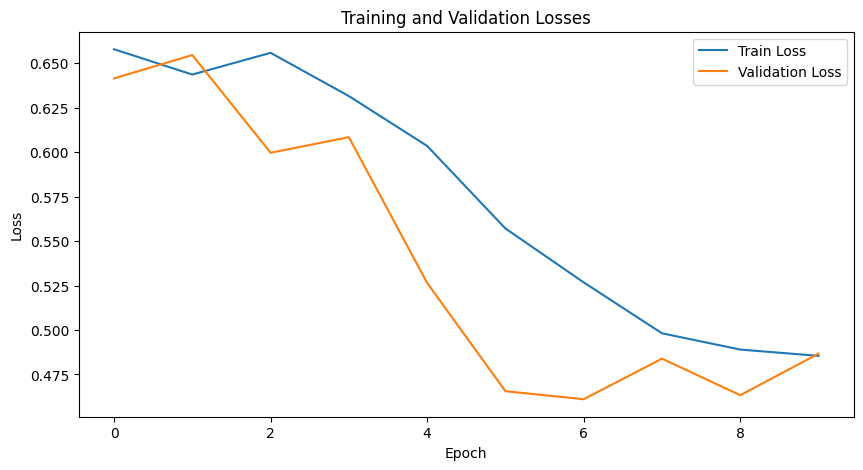

In [70]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение модели, функции потерь, оптимизатора и загрузчиков данных
model = TransformerClassifier(embed_dim=64, num_heads=2, patch_size=32, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

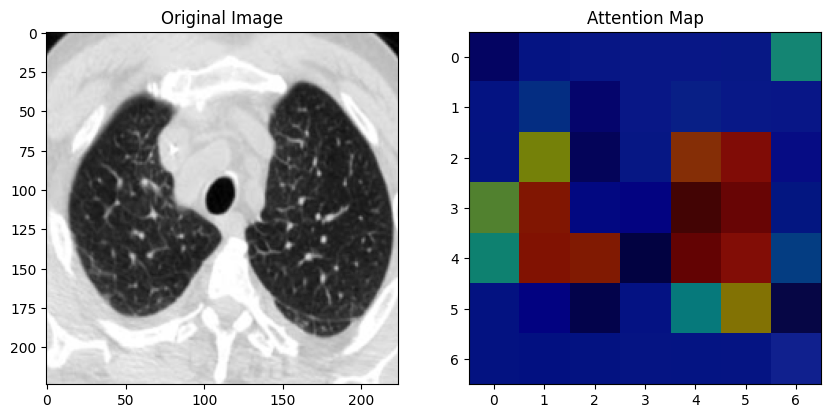

In [71]:
def visualize_attention(model, data_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention_weights = model(inputs)

            # Выберите изображение и соответствующую карту внимания
            img = inputs[0].cpu().numpy().transpose(1, 2, 0).squeeze()
            attn = attention_weights[0].cpu().numpy()

            # Проверка формы карты внимания и ее усреднение по признакам
            if len(attn.shape) == 2 and attn.shape[0] == 49:  # (seq_len, num_features)
                attn = attn.mean(axis=1)  # Усреднение по признакам
                attn_map = attn.reshape(7, 7)  # Преобразование в формат 7x7
            else:
                raise ValueError(f"Unexpected attention shape: {attn.shape}")

            # Визуализация изображения и карты внимания
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(img, cmap='gray')
            plt.imshow(attn_map, cmap='jet', alpha=0.5)  # Среднее значение карты внимания
            plt.title('Attention Map')

            plt.show()

            # Визуализируем только одно изображение
            break

# Визуализация карты внимания на валидационном наборе данных
visualize_attention(model, val_loader)


In [17]:
model

TransformerClassifier(
  (embeddings): Conv2d(1, 64, kernel_size=(32, 32), stride=(32, 32))
  (attention1): SelfAttention(
    (query): Linear(in_features=64, out_features=64, bias=True)
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
    (fc_out): Linear(in_features=64, out_features=64, bias=True)
  )
  (attention2): SelfAttention(
    (query): Linear(in_features=64, out_features=64, bias=True)
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
    (fc_out): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

# Подбор параметров модели

    Теперь, когда мы получили модель которая способна к обучению, а так же смогли получать карты внимания для этой модели. Приступим к исследованию влияния параметров модели на её точность

In [18]:
class TransformerClassifier(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, patch_size=8, num_classes=2, dropout_prob=0.0):
        super(TransformerClassifier, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.dropout = nn.Dropout(p=dropout_prob)  # Добавление дропаута

        # Сверточный слой для встраивания патчей
        self.embeddings = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)

        # Слои self-attention
        self.attention1 = SelfAttention(embed_dim, num_heads)
        self.attention2 = SelfAttention(embed_dim, num_heads)
        self.attention3 = SelfAttention(embed_dim, num_heads)  # Третий слой self-attention

        # Голова классификатора
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape

        # Встраивание патчей
        x = self.embeddings(x).view(B, self.embed_dim, -1).permute(0, 2, 1)  # Изменение формы и перестановка для self-attention

        # Применение self-attention слоев
        attention_weights1 = self.attention1(x)
        attention_weights2 = self.attention2(attention_weights1)
        attention_weights3 = self.attention3(attention_weights2)

        # Полное усреднение
        x = torch.mean(attention_weights3, dim=1)

        # Применение дропаута
        x = self.dropout(x)

        # Голова классификатора
        x = self.fc(x)

        return x, attention_weights1, attention_weights2, attention_weights3

def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=10, params=None):
    train_losses = []  # Список для хранения значений функции потерь на тренировочной выборке
    val_losses = []    # Список для хранения значений функции потерь на валидационной выборке
    val_accuracies = []  # Список для хранения значений точности на валидационной выборке

    for epoch in range(num_epochs):  # Цикл по эпохам обучения
        model.train()  # Установка модели в режим обучения
        running_train_loss = 0.0  # Переменная для накопления значений функции потерь на текущей эпохе
        for inputs, labels in trainloader:  # Цикл по данным из тренировочного загрузчика
            inputs, labels = inputs.to(device), labels.to(device)  # Перенос данных на GPU, если доступно
            optimizer.zero_grad()  # Обнуление градиентов
            outputs, _, _, _ = model(inputs)  # Прямой проход через модель, получение предсказаний и карт внимания
            loss = criterion(outputs, labels)  # Вычисление функции потерь
            loss.backward()  # Обратное распространение градиентов
            optimizer.step()  # Шаг оптимизатора
            running_train_loss += loss.item() * inputs.size(0)  # Накопление значения функции потерь

        epoch_train_loss = running_train_loss / len(trainloader.dataset)  # Вычисление среднего значения функции потерь на эпохе
        train_losses.append(epoch_train_loss)  # Добавление значения функции потерь в список для тренировочной выборки

        # Оценка модели на валидационном датасете
        model.eval()  # Установка модели в режим оценки
        running_val_loss = 0.0  # Переменная для накопления значений функции потерь на валидационной выборке
        correct = 0  # Счетчик правильных предсказаний
        total = 0  # Общее количество данных
        with torch.no_grad():  # Отключение вычисления градиентов
            for inputs, labels in valloader:  # Цикл по данным из валидационного загрузчика
                inputs, labels = inputs.to(device), labels.to(device)  # Перенос данных на GPU, если доступно
                outputs, _, _, _ = model(inputs)  # Прямой проход через модель, получение предсказаний и карт внимания
                loss = criterion(outputs, labels)  # Вычисление функции потерь
                running_val_loss += loss.item() * inputs.size(0)  # Накопление значения функции потерь
                _, predicted = torch.max(outputs, 1)  # Получение индекса класса с максимальной вероятностью
                total += labels.size(0)  # Обновление общего количества данных
                correct += (predicted == labels).sum().item()  # Обновление количества правильных предсказаний

        epoch_val_loss = running_val_loss / len(valloader.dataset)  # Вычисление среднего значения функции потерь на валидационной выборке
        val_losses.append(epoch_val_loss)  # Добавление значения функции потерь в список для валидационной выборки

        # Сохранение точности на валидационной выборке
        accuracy = correct / total  # Вычисление точности
        val_accuracies.append(accuracy)  # Добавление значения точности в список

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {accuracy:.4f}')

    if params:
        return train_losses, val_losses, val_accuracies, params
    else:
        return train_losses, val_losses, val_accuracies

In [26]:
# Определение параметров для перебора
patch_sizes = [8, 16, 32]
num_heads = [1, 2, 4]
dropout_probs = [0.1, 0.3, 0.5]

# Переменные для хранения лучших результатов
best_model = None
best_val_accuracy = 0.0
best_params = None
results = []

# Цикл по всем комбинациям параметров
for patch_size, num_head, dropout_prob in itertools.product(patch_sizes, num_heads, dropout_probs):
    # Создание модели с текущими параметрами
    model = TransformerClassifier(embed_dim=64, num_heads=num_head, patch_size=patch_size, num_classes=2, dropout_prob=dropout_prob).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=12)

    # Сохранение результатов
    results.append({
        'patch_size': patch_size,
        'num_heads': num_head,
        'dropout_prob': dropout_prob,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    })

    # Проверка на лучшую точность на валидации
    if val_accuracies[-1] > best_val_accuracy:
        best_val_accuracy = val_accuracies[-1]
        best_model = model
        best_params = (patch_size, num_head, dropout_prob)

# Вывод лучших результатов
print('-' * 70)
print(f'Best Validation Accuracy: {best_val_accuracy:.4f} for model with parameters: {best_params}')


Epoch [1/12], Train Loss: 0.6573, Val Loss: 0.6191, Val Accuracy: 0.6137
Epoch [2/12], Train Loss: 0.6304, Val Loss: 0.5948, Val Accuracy: 0.6620
Epoch [3/12], Train Loss: 0.6294, Val Loss: 0.6022, Val Accuracy: 0.6660
Epoch [4/12], Train Loss: 0.6256, Val Loss: 0.5996, Val Accuracy: 0.6579
Epoch [5/12], Train Loss: 0.6180, Val Loss: 0.5609, Val Accuracy: 0.6962
Epoch [6/12], Train Loss: 0.6146, Val Loss: 0.6288, Val Accuracy: 0.6479
Epoch [7/12], Train Loss: 0.6267, Val Loss: 0.6120, Val Accuracy: 0.6620
Epoch [8/12], Train Loss: 0.6396, Val Loss: 0.6307, Val Accuracy: 0.6660
Epoch [9/12], Train Loss: 0.6403, Val Loss: 0.5875, Val Accuracy: 0.6660
Epoch [10/12], Train Loss: 0.5983, Val Loss: 0.5495, Val Accuracy: 0.7082
Epoch [11/12], Train Loss: 0.6368, Val Loss: 0.6176, Val Accuracy: 0.6499
Epoch [12/12], Train Loss: 0.6343, Val Loss: 0.6092, Val Accuracy: 0.6720
Epoch [1/12], Train Loss: 0.6710, Val Loss: 0.6273, Val Accuracy: 0.6318
Epoch [2/12], Train Loss: 0.6335, Val Loss: 0.63

In [30]:
print(f'Best Validation Accuracy: {best_val_accuracy:.4f} for model with parameters: {best_params}')

Best Validation Accuracy: 0.8270 for model with parameters: (16, 4, 0.3)


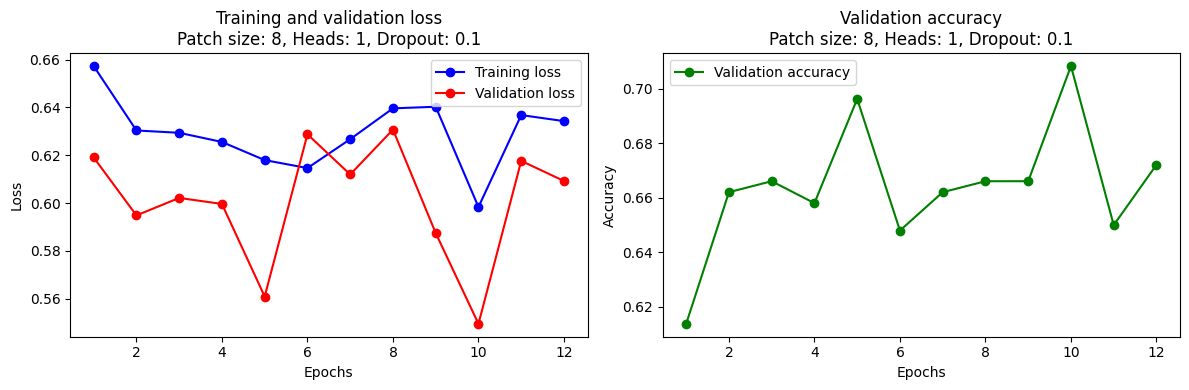

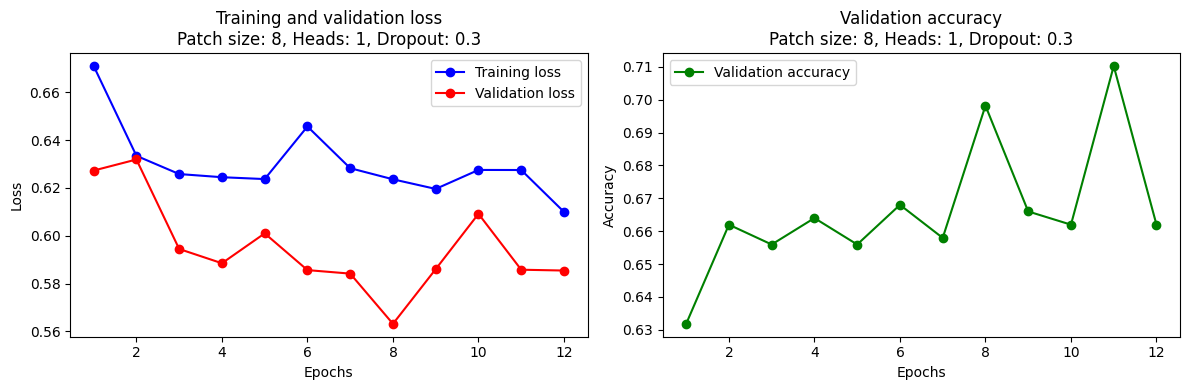

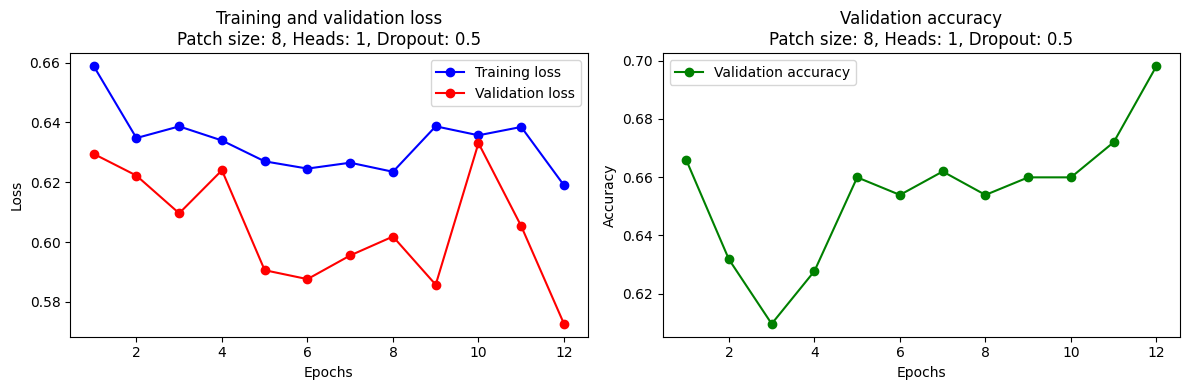

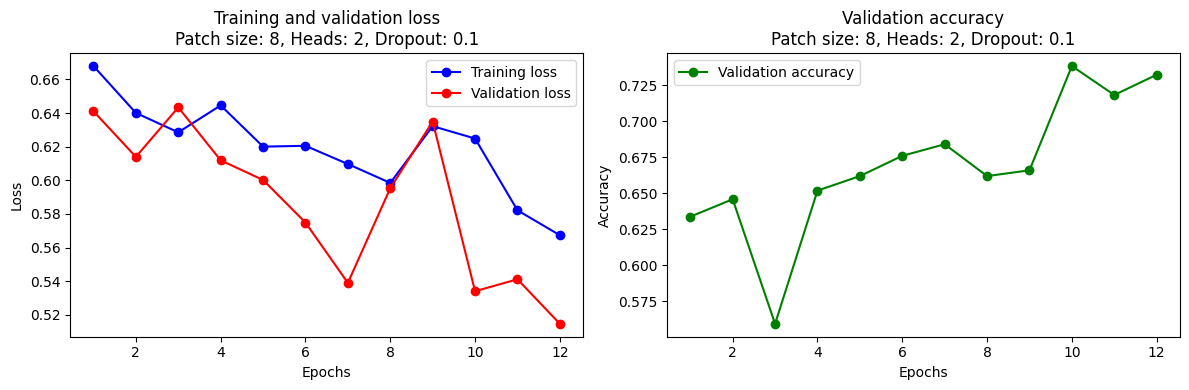

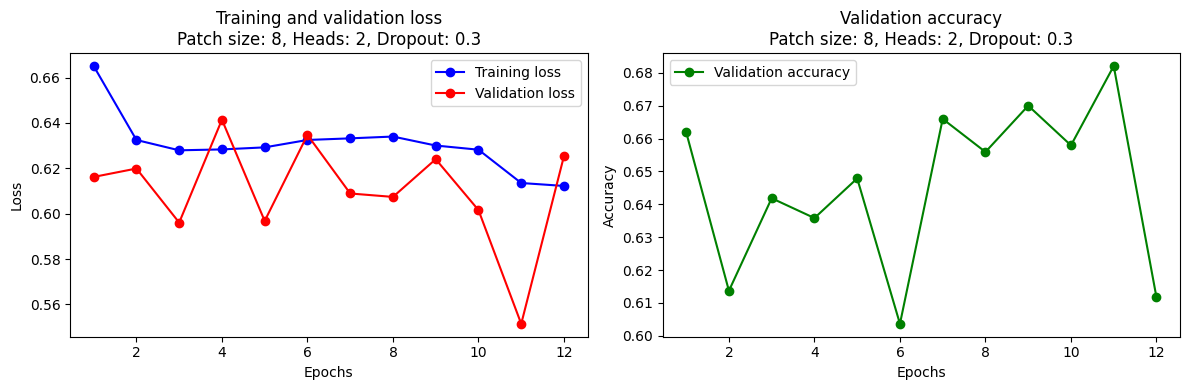

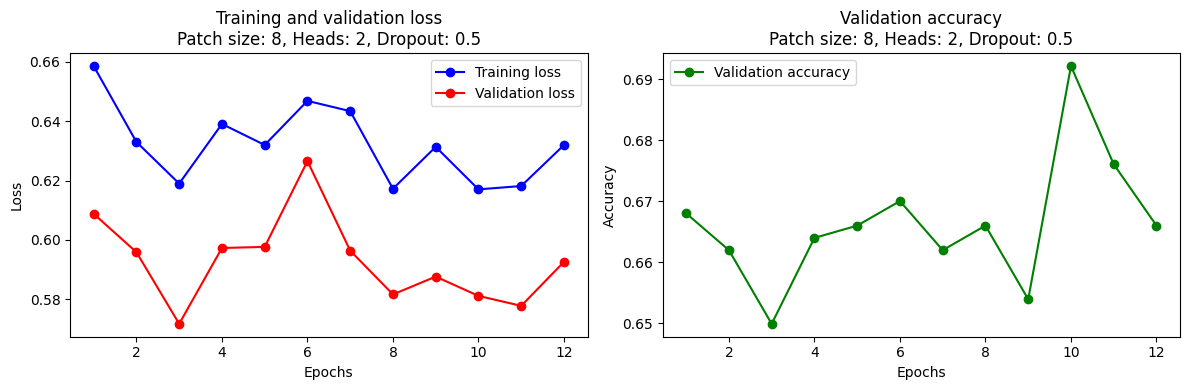

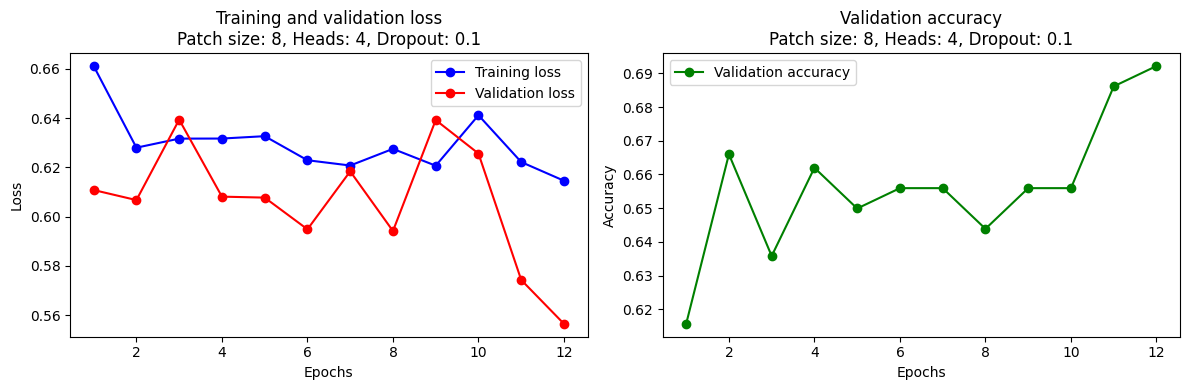

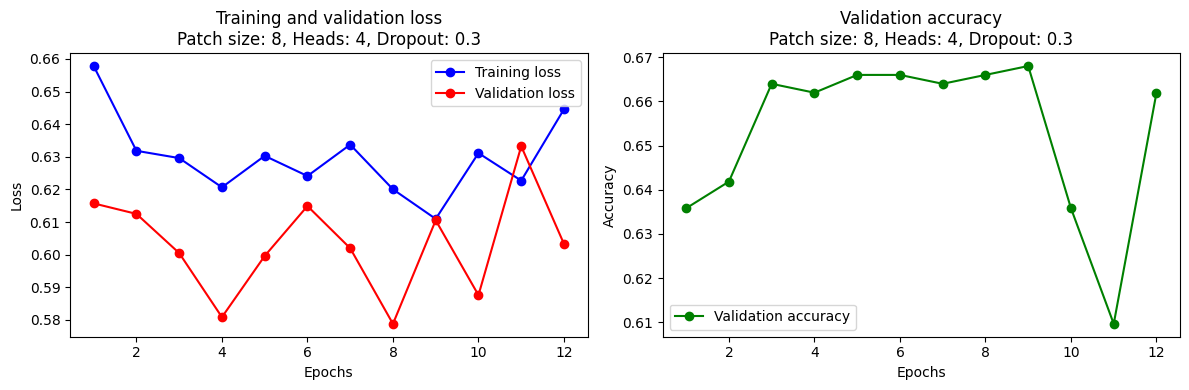

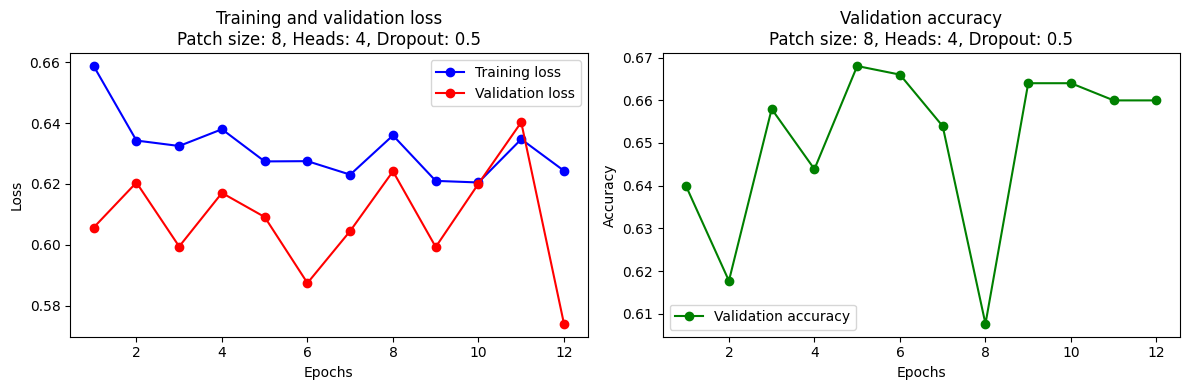

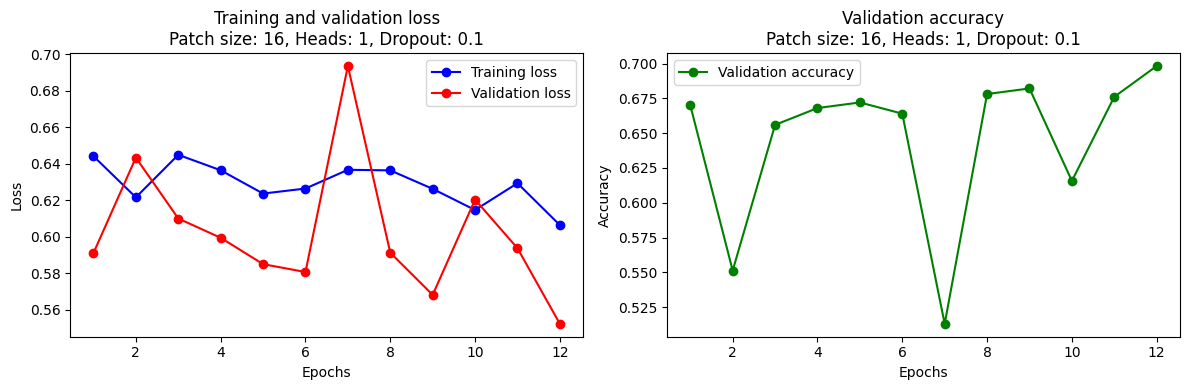

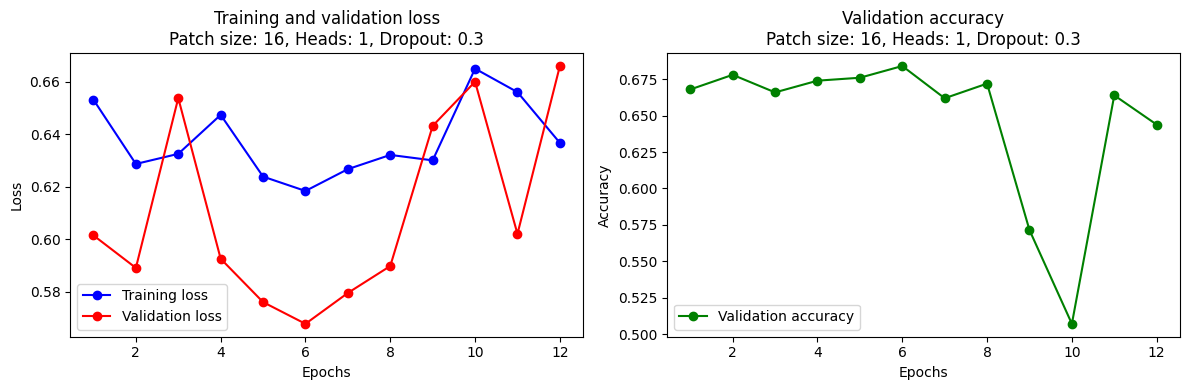

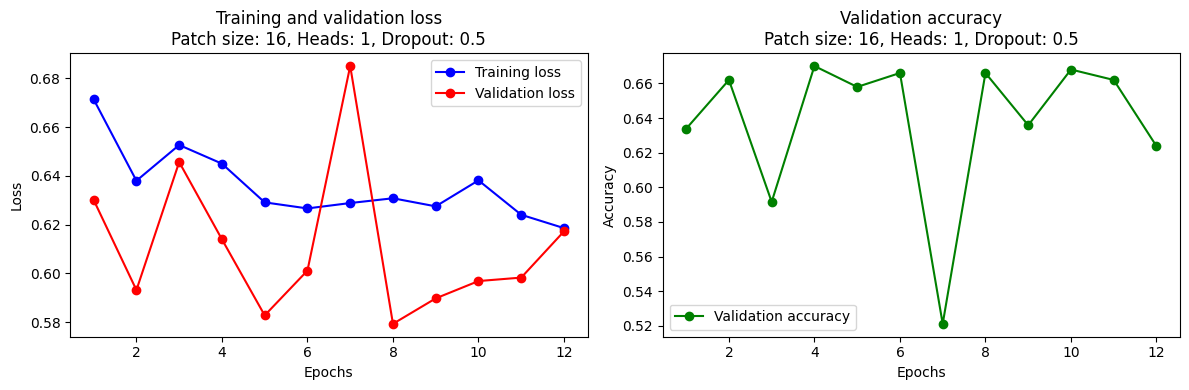

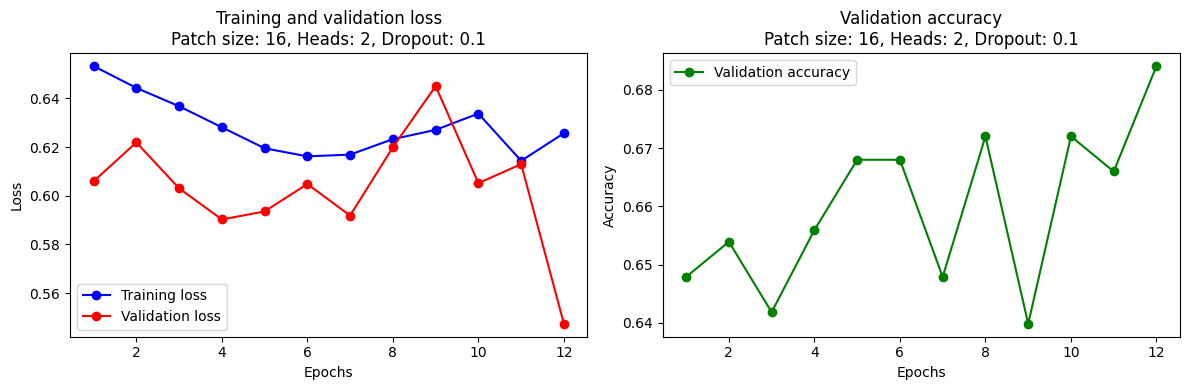

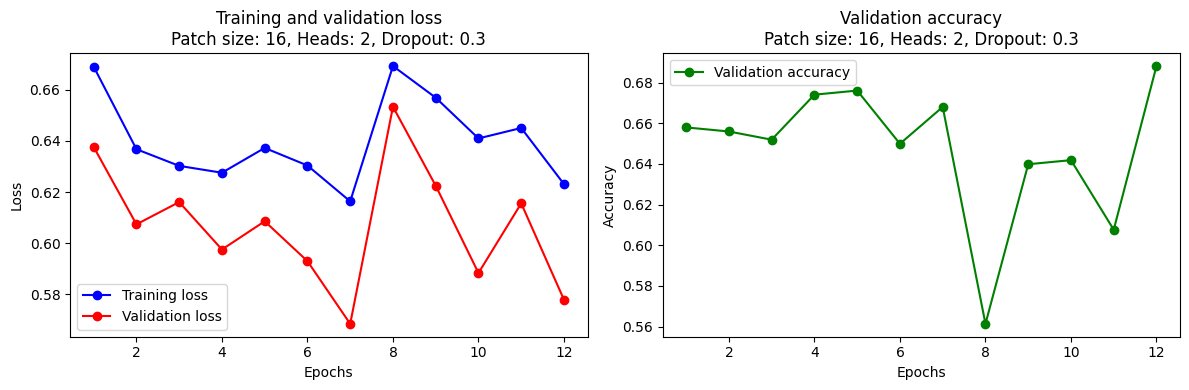

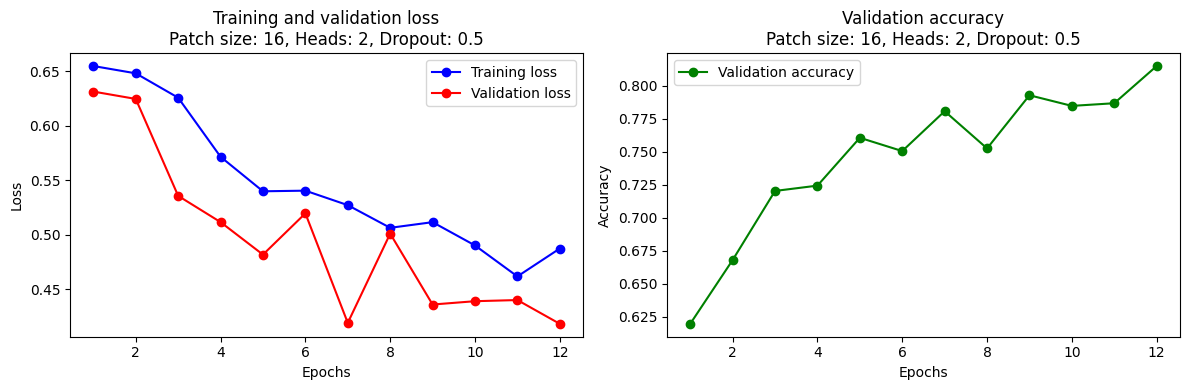

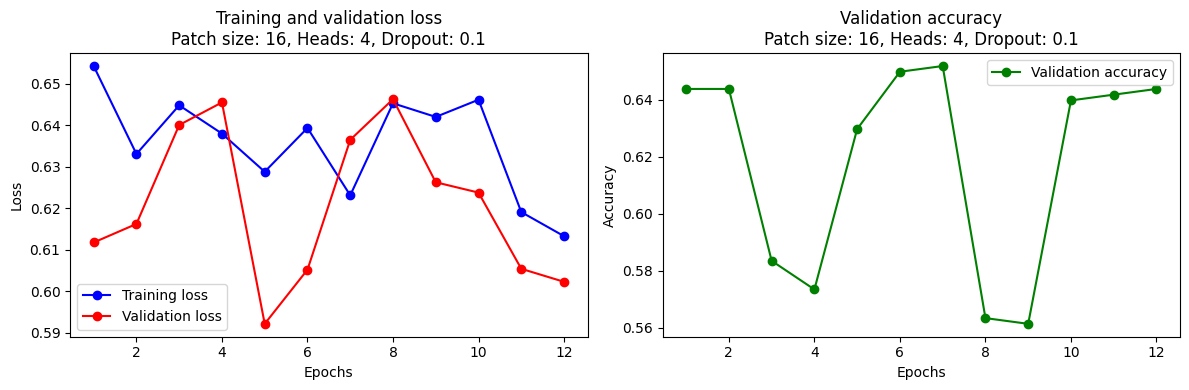

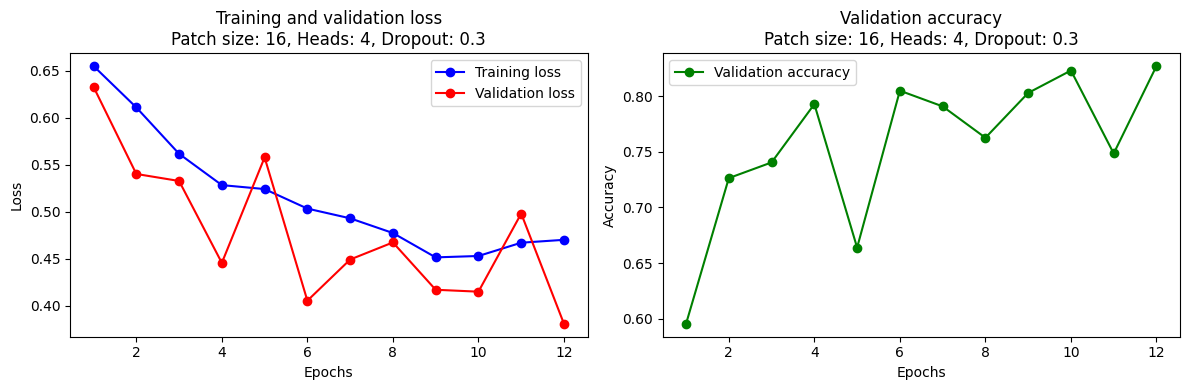

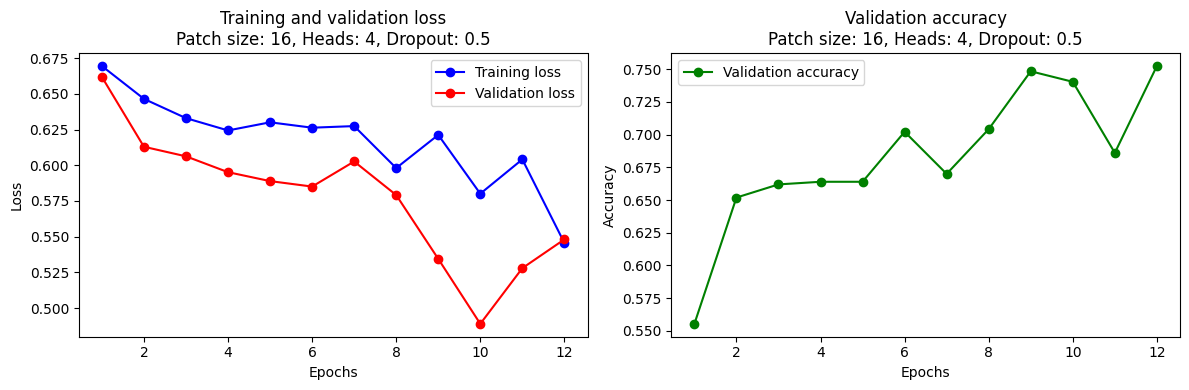

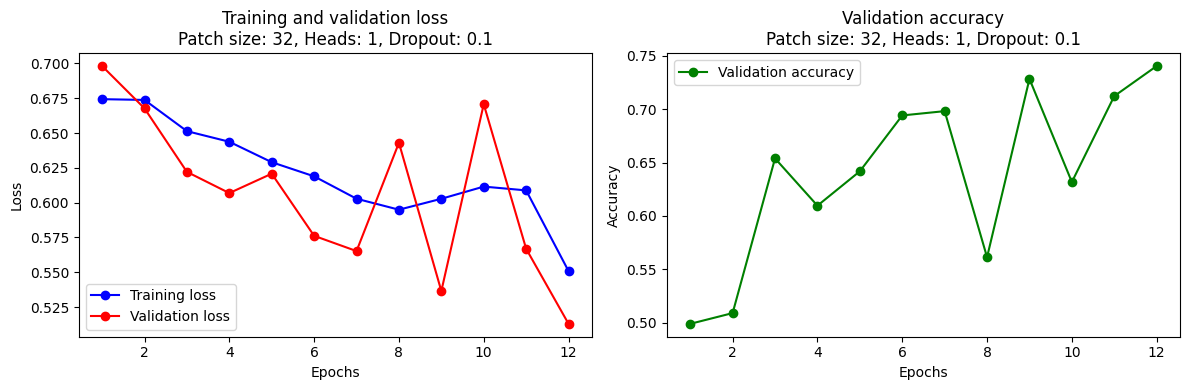

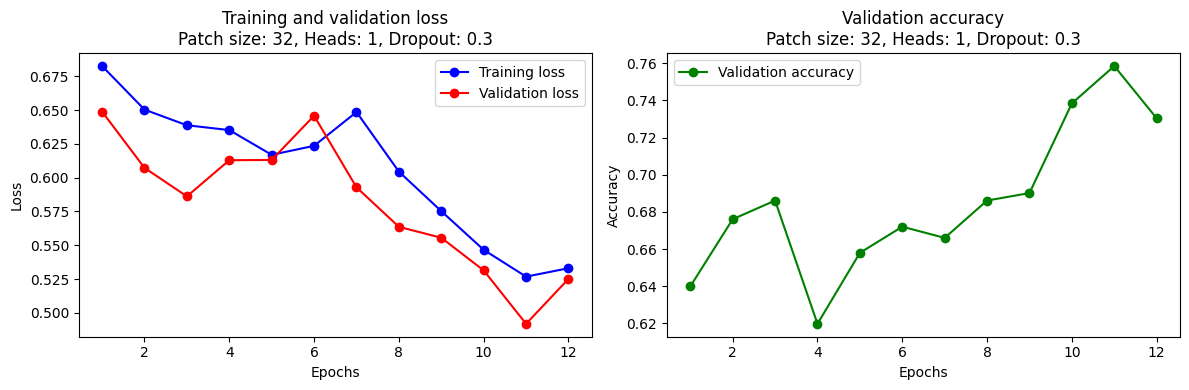

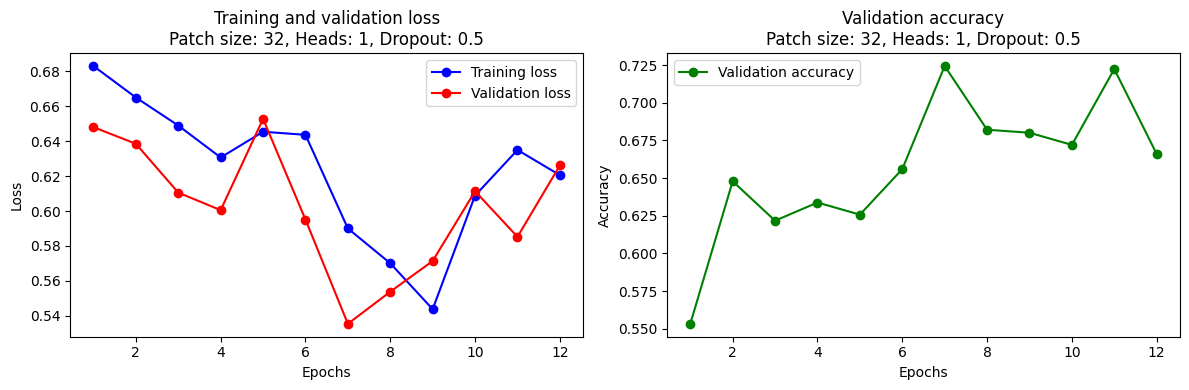

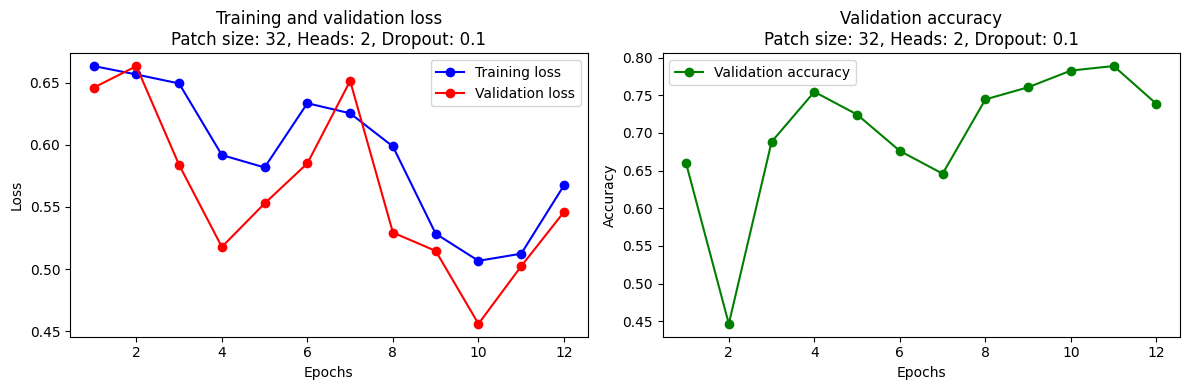

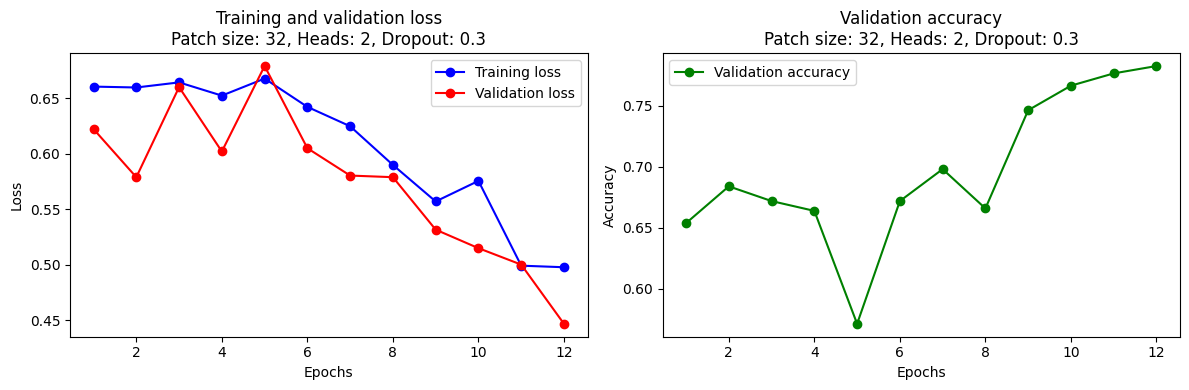

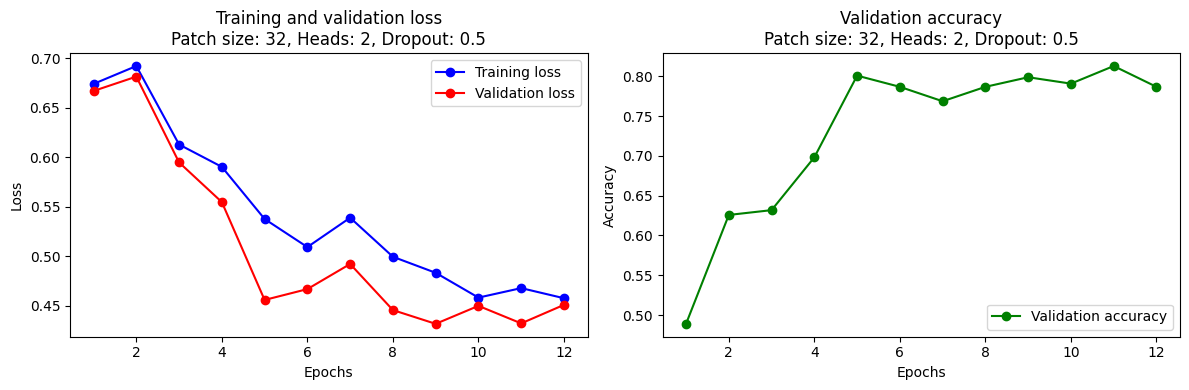

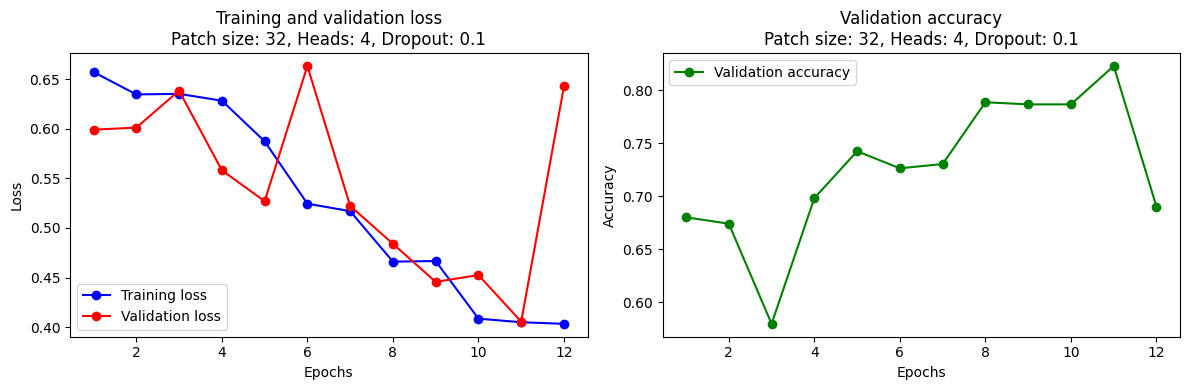

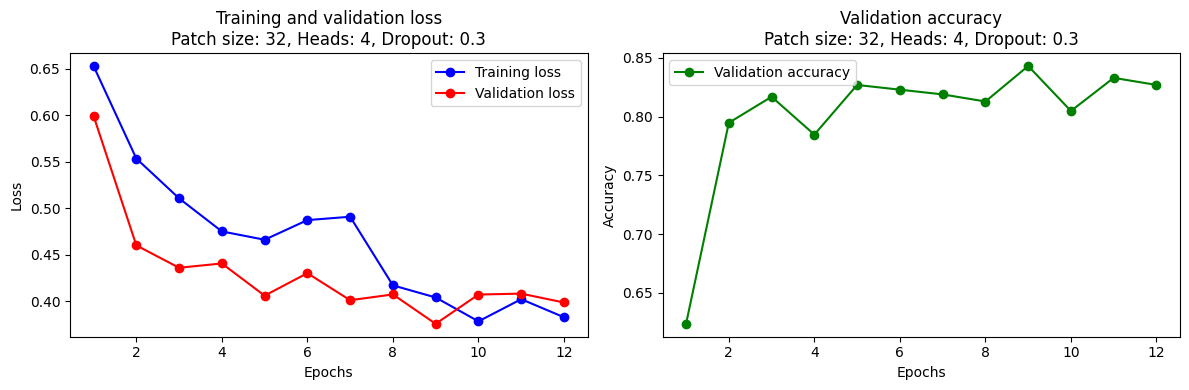

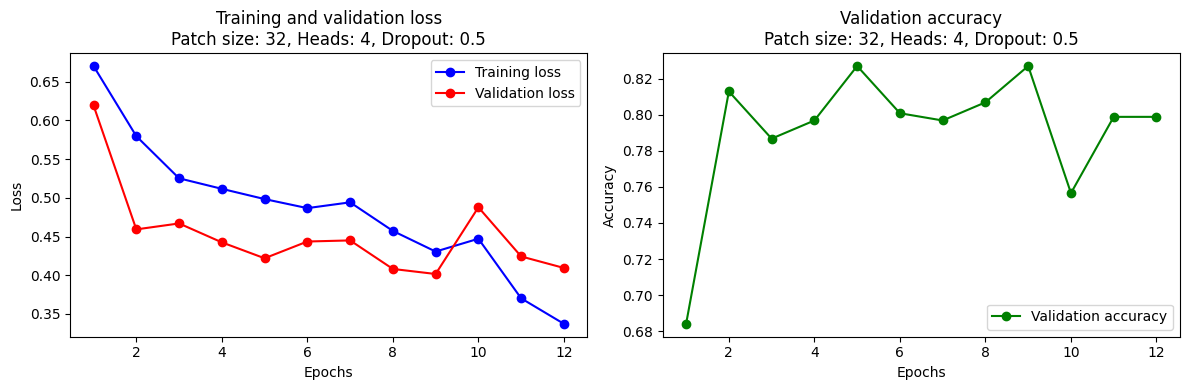

In [31]:
# Пример визуализации потерь и точностей для одного набора параметров
def plot_training_results(results):
    for result in results:
        patch_size = result['patch_size']
        num_heads = result['num_heads']
        dropout_prob = result['dropout_prob']
        train_losses = result['train_losses']
        val_losses = result['val_losses']
        val_accuracies = result['val_accuracies']

        epochs = range(1, len(train_losses) + 1)

        # Потери на тренировочном и валидационном наборах
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'bo-', label='Training loss')
        plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
        plt.title(f'Training and validation loss\nPatch size: {patch_size}, Heads: {num_heads}, Dropout: {dropout_prob}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Точность на валидационном наборе
        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_accuracies, 'go-', label='Validation accuracy')
        plt.title(f'Validation accuracy\nPatch size: {patch_size}, Heads: {num_heads}, Dropout: {dropout_prob}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Вызов функции для визуализации результатов
plot_training_results(results)


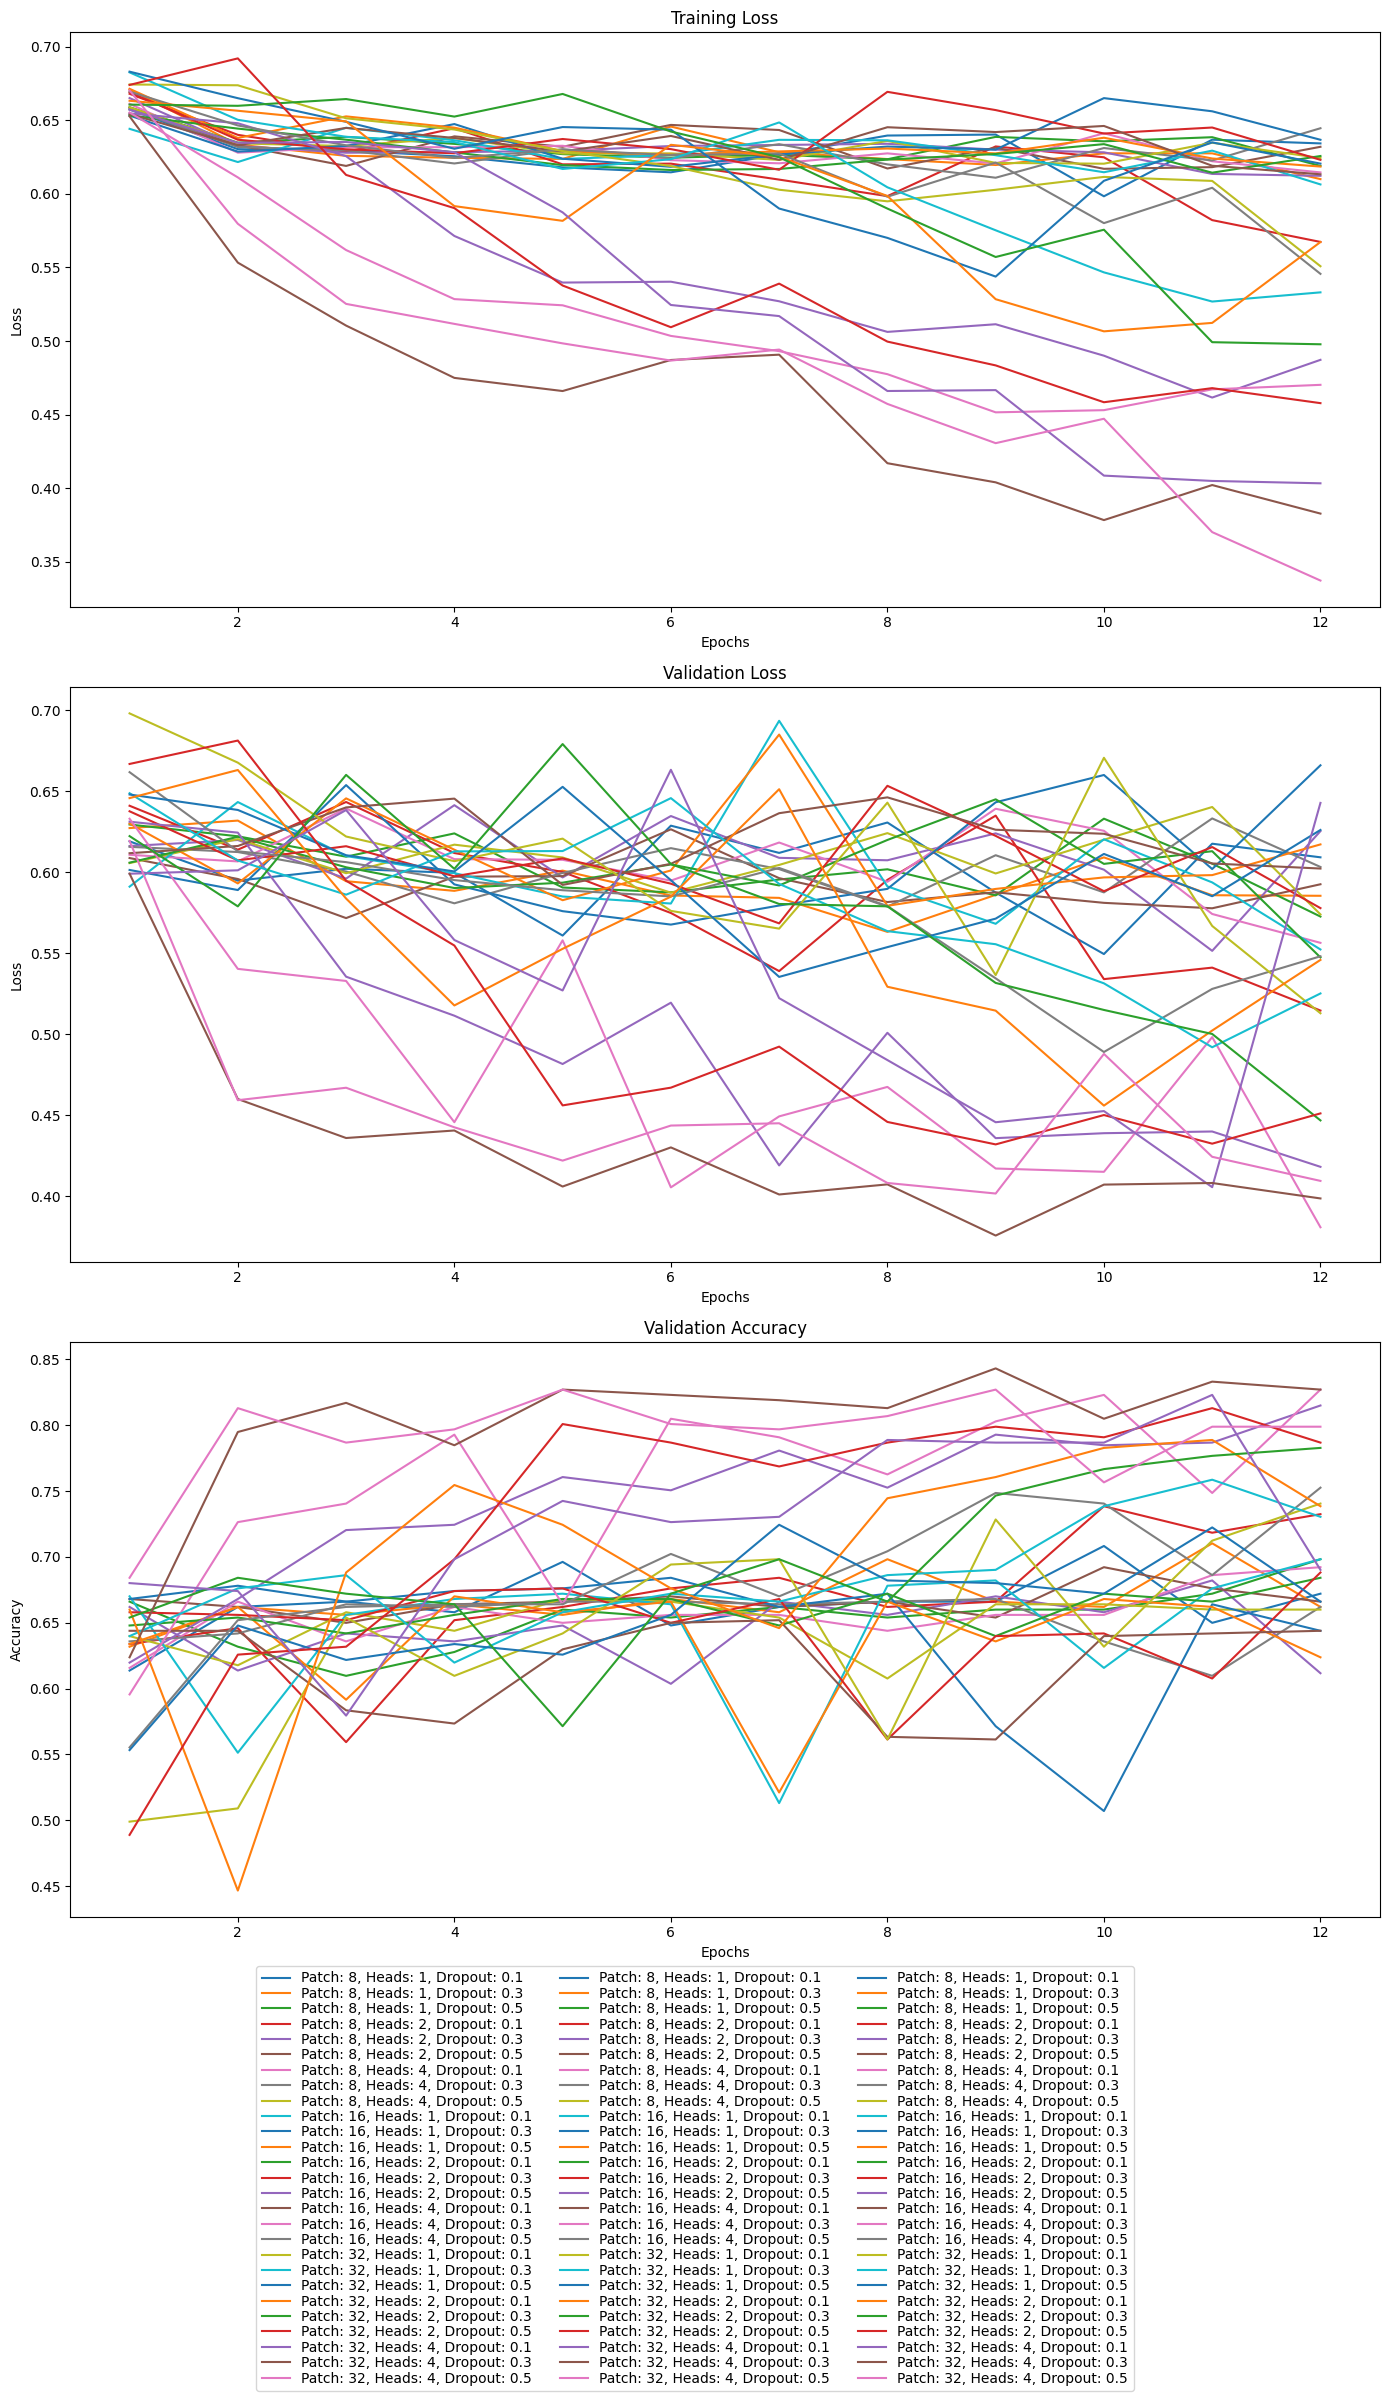

In [42]:
def plot_combined_training_results(results):
    epochs = range(1, len(results[0]['train_losses']) + 1)

    plt.figure(figsize=(14, 12))

    # Потери на тренировочном наборе
    plt.subplot(3, 1, 1)
    for result in results:
        label = f'Patch: {result["patch_size"]}, Heads: {result["num_heads"]}, Dropout: {result["dropout_prob"]}'
        plt.plot(epochs, result['train_losses'], label=label)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Потери на валидационном наборе
    plt.subplot(3, 1, 2)
    for result in results:
        label = f'Patch: {result["patch_size"]}, Heads: {result["num_heads"]}, Dropout: {result["dropout_prob"]}'
        plt.plot(epochs, result['val_losses'], label=label)
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Точность на валидационном наборе
    plt.subplot(3, 1, 3)
    for result in results:
        label = f'Patch: {result["patch_size"]}, Heads: {result["num_heads"]}, Dropout: {result["dropout_prob"]}'
        plt.plot(epochs, result['val_accuracies'], label=label)
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Добавление общей легенды снизу
    plt.figlegend(loc='lower center', ncol=3, labelspacing=0.1)

    plt.tight_layout(rect=[0, 0.35, 1, 2])  # Оставляем место для легенды снизу
    plt.show()

# Вызов функции для визуализации результатов
plot_combined_training_results(results)

In [33]:
print(f'Best Validation Accuracy: {best_val_accuracy:.4f} for model with parameters: {best_params}')


# Best Validation Accuracy: 0.8270 for model with parameters: (16, 4, 0.3)

Best Validation Accuracy: 0.8270 for model with parameters: (16, 4, 0.3)


# Обучение выбранной модели
    Получив парметры которые дают наиболее точные результаты для моделей. Попробуем обучить модель с применением большего колличества слоёв self attention, так же попробуюем визуализировать карты внимания для обученной нами модели

In [97]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(SelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.fc_out = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        query = self.query(x).view(B, N, self.num_heads, self.head_dim)
        key = self.key(x).view(B, N, self.num_heads, self.head_dim)
        value = self.value(x).view(B, N, self.num_heads, self.head_dim)

        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        attention_scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        out = torch.matmul(attention_weights, value)

        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(B, N, C)

        out = self.fc_out(out)

        return out, attention_weights
    
    
class TransformerClassifier(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, patch_size=32, num_classes=2, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.embeddings = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.attention1 = SelfAttention(embed_dim, num_heads, dropout)
        self.attention2 = SelfAttention(embed_dim, num_heads, dropout)

        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.embeddings(x).view(B, self.embed_dim, -1).permute(0, 2, 1)

        x, attention_weights1 = self.attention1(x)
        x, attention_weights2 = self.attention2(x)

        x = torch.mean(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)

        return x, (attention_weights1, attention_weights2)

In [114]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=10):
    train_losses = []   # Список для хранения значений функции потерь на тренировочном наборе
    val_losses = []     # Список для хранения значений функции потерь на валидационном наборе
    val_accuracies = [] # Список для хранения значений точности на валидационном наборе

    # Цикл по эпохам обучения
    for epoch in range(num_epochs):
        model.train()  # Перевод модели в режим обучения
        running_train_loss = 0.0  # Переменная для хранения текущей суммарной потери на тренировочной выборке

        # Цикл по данным тренировочного загрузчика
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Перенос данных на GPU, если доступен
            optimizer.zero_grad()  # Обнуление градиентов параметров модели
            outputs, _ = model(inputs)  # Передача данных через модель для получения предсказаний (и игнорирования весов внимания)
            loss = criterion(outputs, labels)  # Вычисление функции потерь
            loss.backward()  # Обратное распространение ошибки
            optimizer.step()  # Обновление параметров модели на основе градиентов
            running_train_loss += loss.item() * inputs.size(0)  # Обновление суммарной потери

        epoch_train_loss = running_train_loss / len(trainloader.dataset)  # Вычисление средней потери на одном обучающем батче
        train_losses.append(epoch_train_loss)  # Добавление текущей потери в список потерь обучения

        # Оценка на валидационном наборе данных
        model.eval()  # Перевод модели в режим оценки (выключение dropout и batch normalization)
        running_val_loss = 0.0  # Переменная для хранения текущей суммарной потери на валидационной выборке
        correct = 0  # Количество правильно предсказанных примеров
        total = 0  # Общее количество примеров

        with torch.no_grad():
            # Цикл по данным валидационного загрузчика
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)  # Перенос данных на GPU, если доступен
                outputs, _ = model(inputs)  # Передача данных через модель для получения предсказаний (и игнорирования весов внимания)
                loss = criterion(outputs, labels)  # Вычисление функции потерь
                running_val_loss += loss.item() * inputs.size(0)  # Обновление суммарной потери на валидационном батче
                _, predicted = torch.max(outputs, 1)  # Получение предсказанных классов
                total += labels.size(0)  # Обновление общего числа примеров
                correct += (predicted == labels).sum().item()  # Обновление количества правильно предсказанных примеров

        epoch_val_loss = running_val_loss / len(valloader.dataset)  # Вычисление средней потери на одном валидационном батче
        val_losses.append(epoch_val_loss)  # Добавление текущей потери в список потерь валидации

        # Сохранение точности на валидационном наборе данных
        accuracy = correct / total  # Вычисление точности
        val_accuracies.append(accuracy)  # Добавление текущей точности в список точностей валидации

        # Вывод результатов текущей эпохи обучения
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {accuracy:.4f}')

    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')  # График потерь на тренировочном наборе
    plt.plot(val_losses, label='Validation Loss')  # График потерь на валидационном наборе
    plt.xlabel('Epoch')  # Метка оси X
    plt.ylabel('Loss')  # Метка оси Y
    plt.title('Training and Validation Losses')  # Заголовок графика
    plt.legend()  # Отображение легенды
    plt.show()  # Отображение граф

Epoch [1/5], Train Loss: 0.6622, Val Loss: 0.6340, Val Accuracy: 0.6278
Epoch [2/5], Train Loss: 0.6348, Val Loss: 0.5817, Val Accuracy: 0.6720
Epoch [3/5], Train Loss: 0.6075, Val Loss: 0.5582, Val Accuracy: 0.7143
Epoch [4/5], Train Loss: 0.6072, Val Loss: 0.6258, Val Accuracy: 0.5211
Epoch [5/5], Train Loss: 0.6175, Val Loss: 0.5215, Val Accuracy: 0.7304


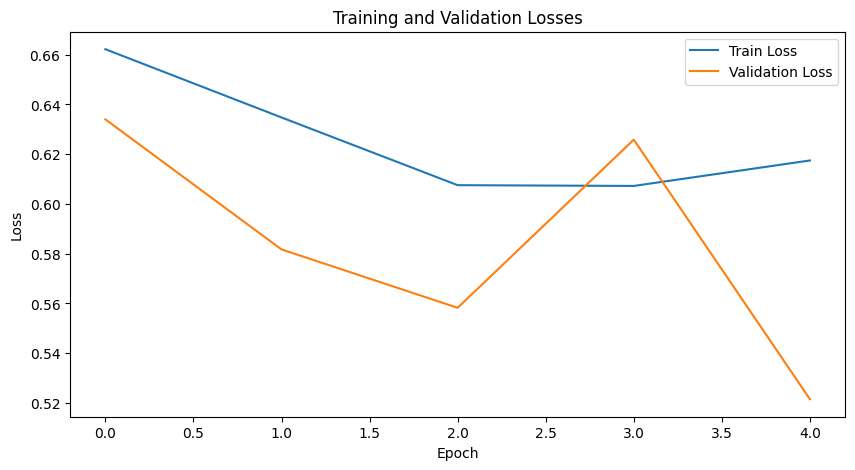

In [112]:
# Define model, loss function, optimizer, and data loaders
model = TransformerClassifier(embed_dim=64, num_heads=4, patch_size=16, num_classes=2, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Обучение модели
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

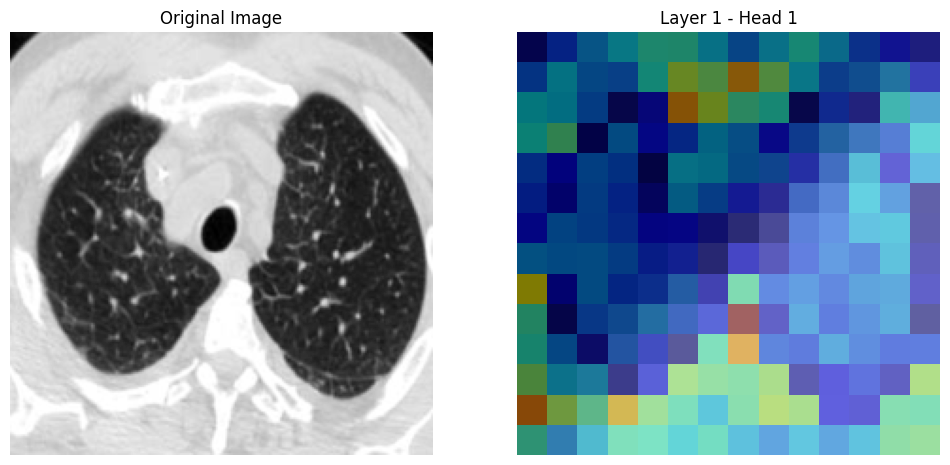

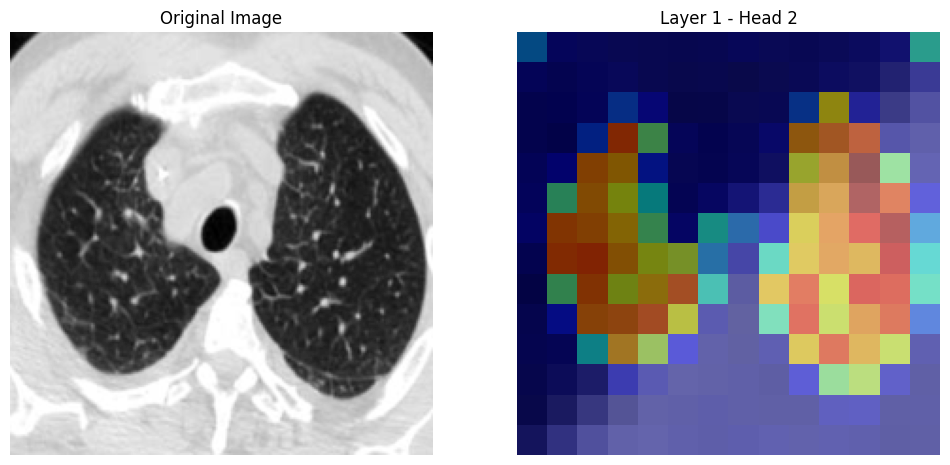

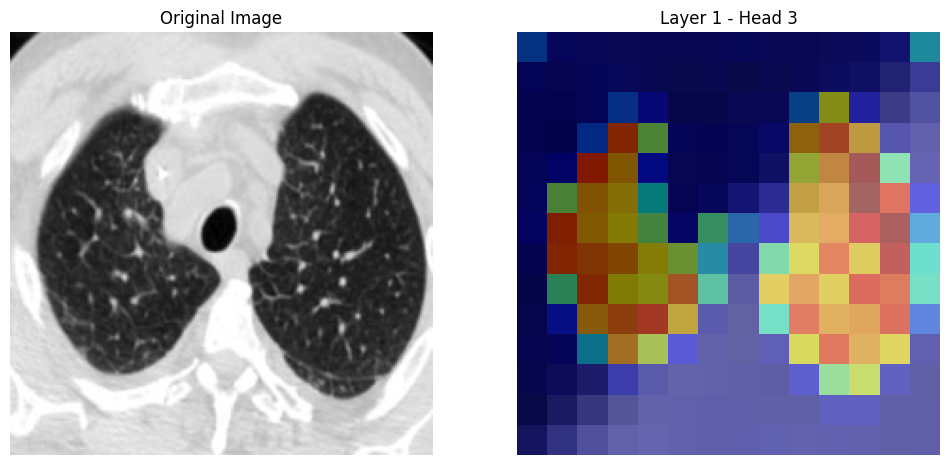

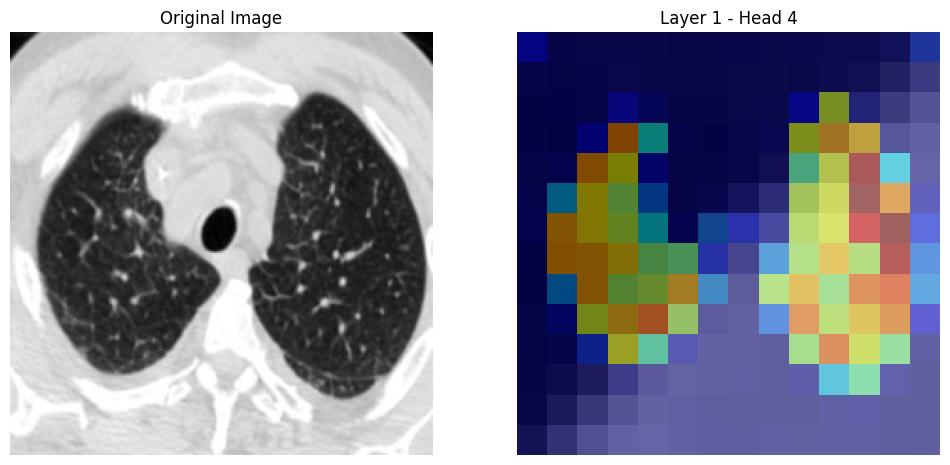

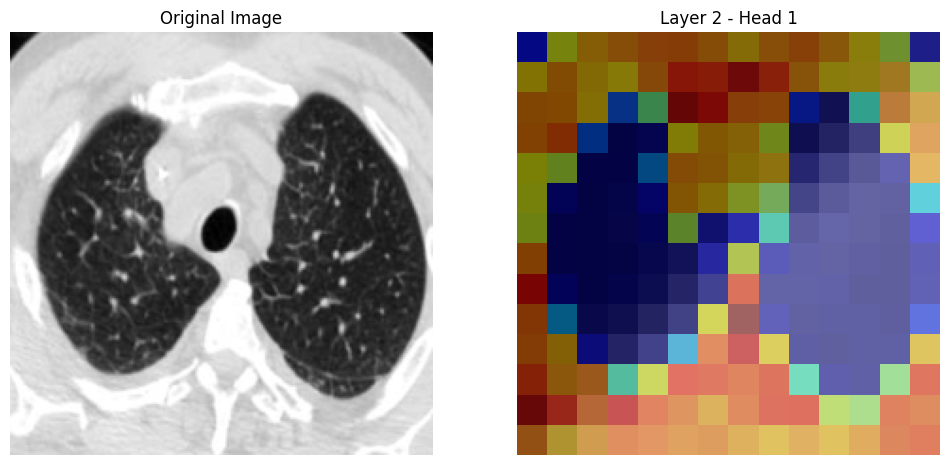

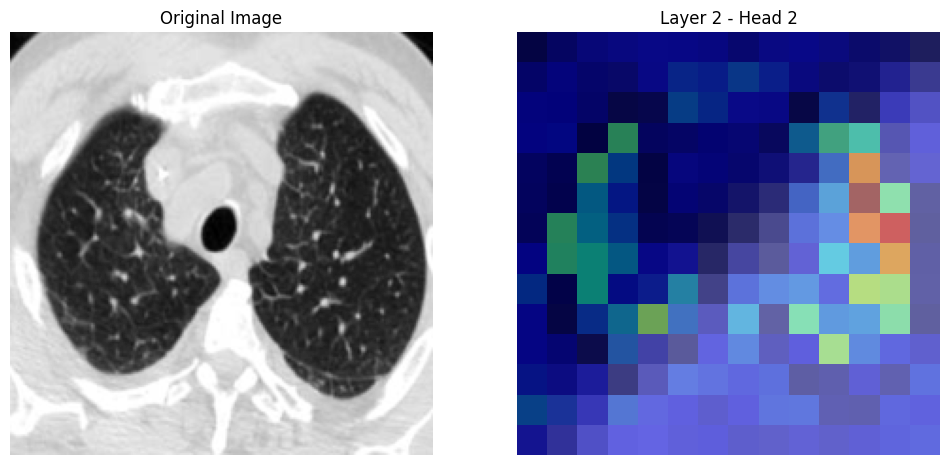

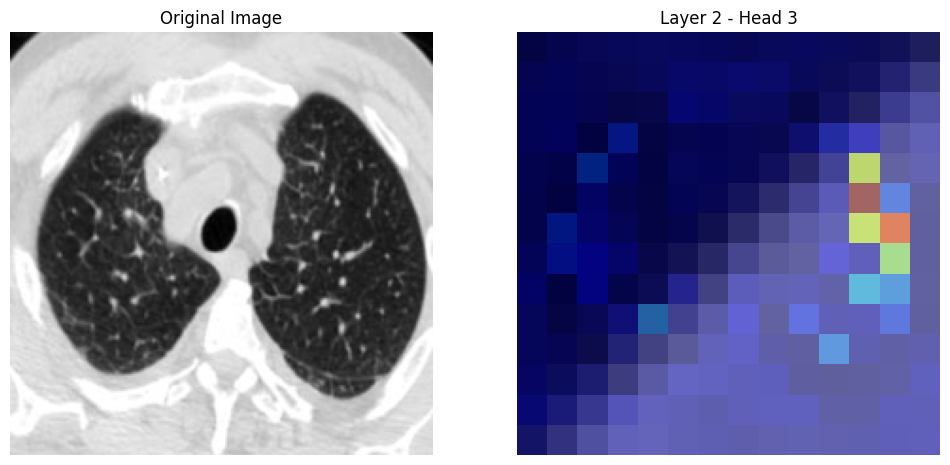

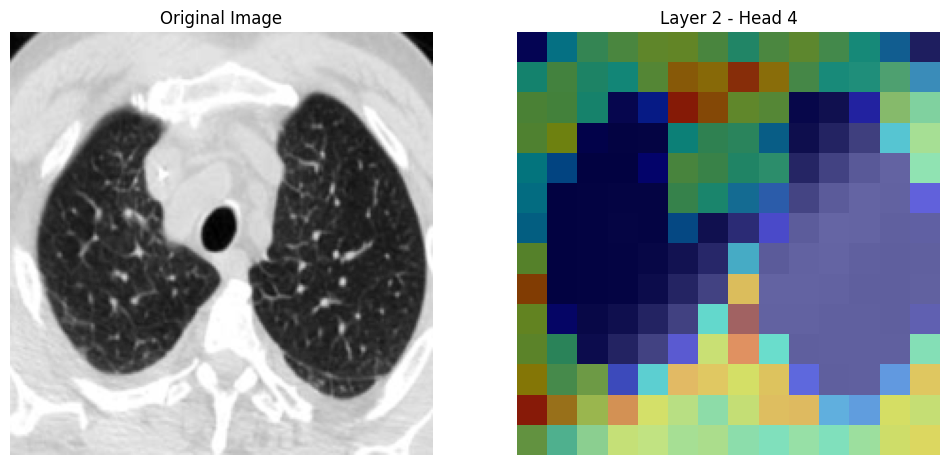

In [113]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(model, data_loader, num_heads=4):
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention_weights = model(inputs)

            # Выберите изображение
            img = inputs[0].cpu().numpy().transpose(1, 2, 0).squeeze()

            # Визуализация для каждого слоя и каждой головы
            for layer_idx, layer_attention in enumerate(attention_weights):
                layer_attention = layer_attention[0].cpu().numpy()  # (num_heads, seq_len, seq_len)
                
                for head_idx in range(num_heads):
                    attn = layer_attention[head_idx]  # (seq_len, seq_len)

                    # Усреднение по временной оси
                    attn_map = attn.mean(axis=0).reshape(14, 14)  # Преобразование в формат 14x14

                    # Визуализация изображения и карты внимания
                    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

                    axs[0].imshow(img, cmap='gray')
                    axs[0].set_title('Original Image')
                    axs[0].axis('off')

                    axs[1].imshow(img, cmap='gray')
                    axs[1].imshow(attn_map, cmap='jet', alpha=0.5)  # Среднее значение карты внимания
                    axs[1].set_title(f'Layer {layer_idx + 1} - Head {head_idx + 1}')
                    axs[1].axis('off')

                    plt.show()

            # Визуализируем только одно изображение
            break

# Визуализация карты внимания на валидационном наборе данных
visualize_attention(model, val_loader, num_heads=4)

Epoch [1/20], Train Loss: 0.6608, Val Loss: 0.6175, Val Accuracy: 0.6600
Epoch [2/20], Train Loss: 0.6436, Val Loss: 0.6505, Val Accuracy: 0.5996
Epoch [3/20], Train Loss: 0.6420, Val Loss: 0.6146, Val Accuracy: 0.6700
Epoch [4/20], Train Loss: 0.6390, Val Loss: 0.6057, Val Accuracy: 0.6519
Epoch [5/20], Train Loss: 0.6185, Val Loss: 0.5792, Val Accuracy: 0.6761
Epoch [6/20], Train Loss: 0.6080, Val Loss: 0.5749, Val Accuracy: 0.6881
Epoch [7/20], Train Loss: 0.6132, Val Loss: 0.5729, Val Accuracy: 0.6881
Epoch [8/20], Train Loss: 0.5763, Val Loss: 0.5204, Val Accuracy: 0.7264
Epoch [9/20], Train Loss: 0.5950, Val Loss: 0.5570, Val Accuracy: 0.6901
Epoch [10/20], Train Loss: 0.5444, Val Loss: 0.5074, Val Accuracy: 0.7425
Epoch [11/20], Train Loss: 0.5133, Val Loss: 0.4911, Val Accuracy: 0.7626
Epoch [12/20], Train Loss: 0.5247, Val Loss: 0.4587, Val Accuracy: 0.7726
Epoch [13/20], Train Loss: 0.4742, Val Loss: 0.5334, Val Accuracy: 0.6841
Epoch [14/20], Train Loss: 0.4995, Val Loss: 0.

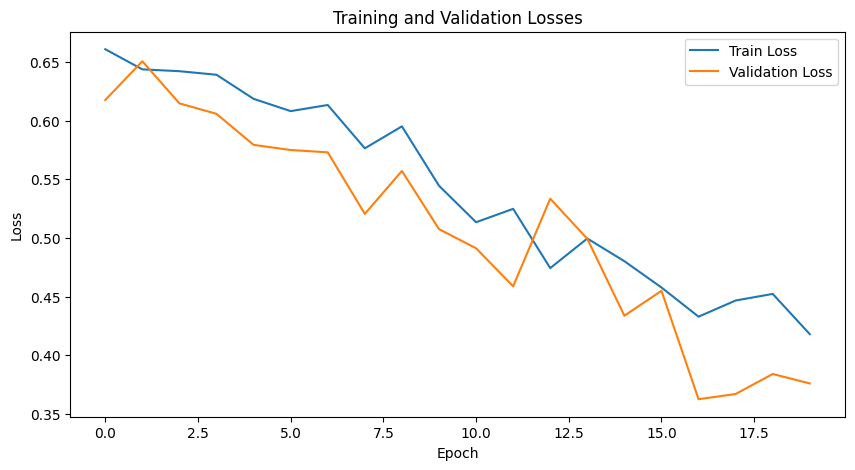

In [120]:
# Define model, loss function, optimizer, and data loaders
model = TransformerClassifier(embed_dim=64, num_heads=4, patch_size=16, num_classes=2, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Обучение модели
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

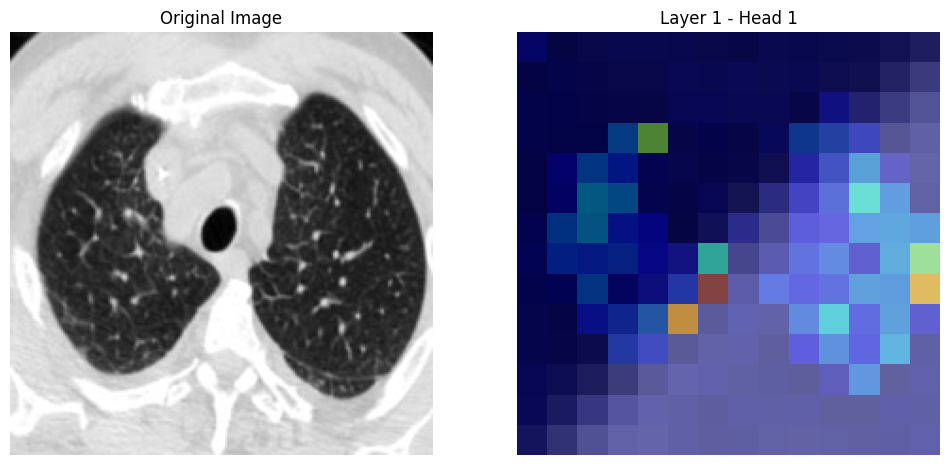

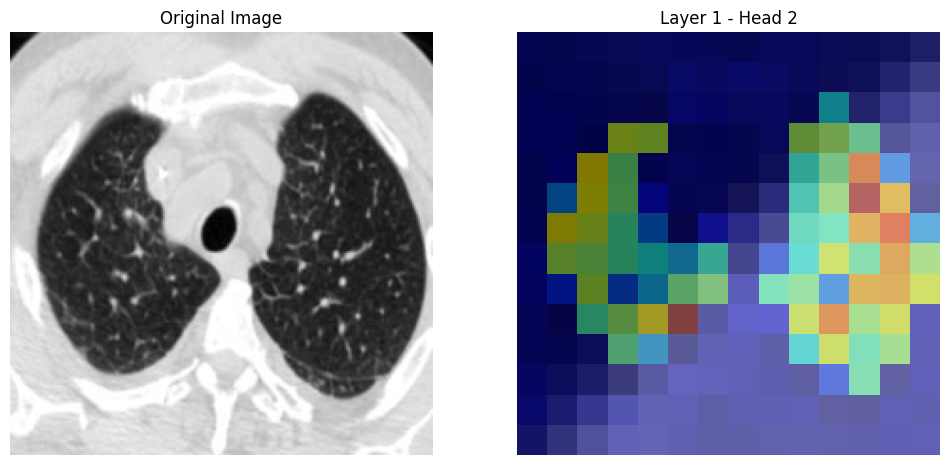

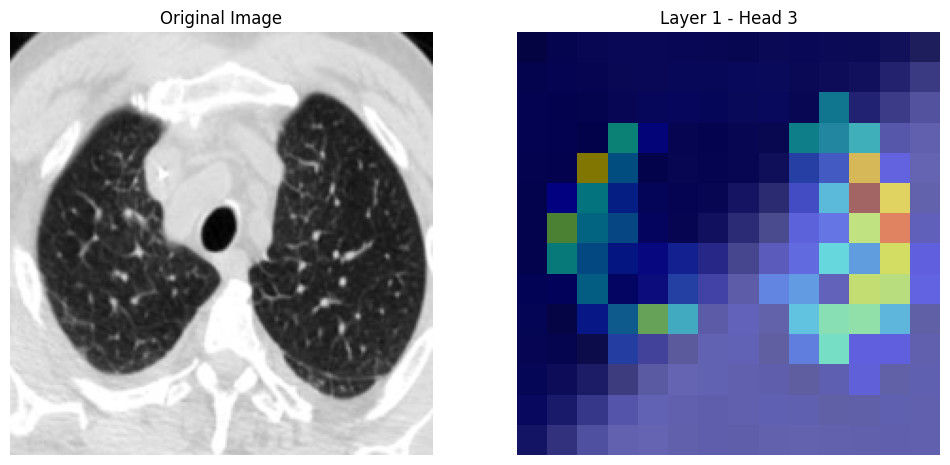

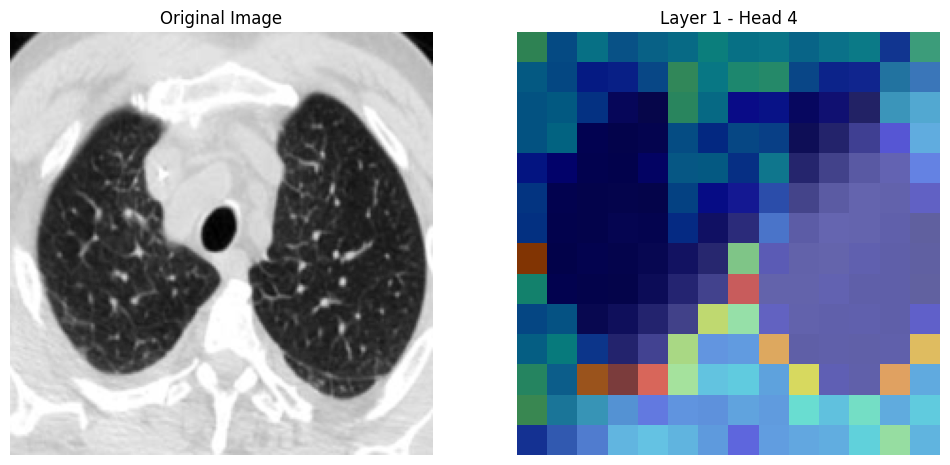

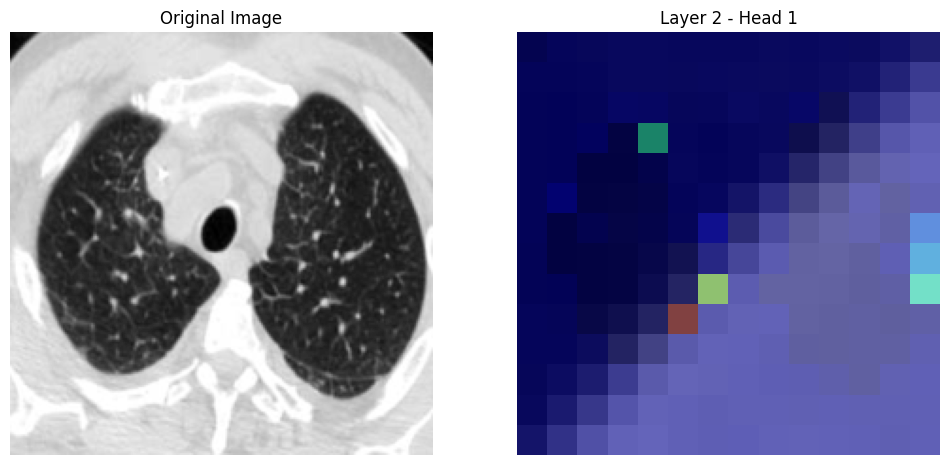

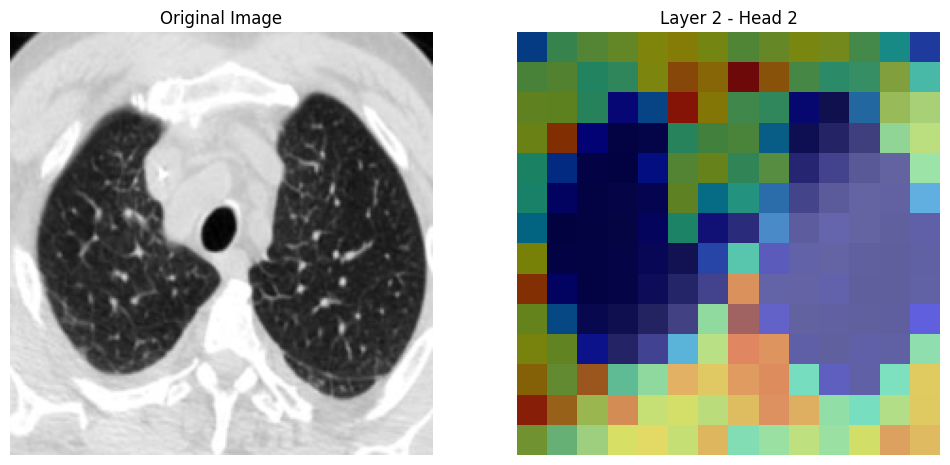

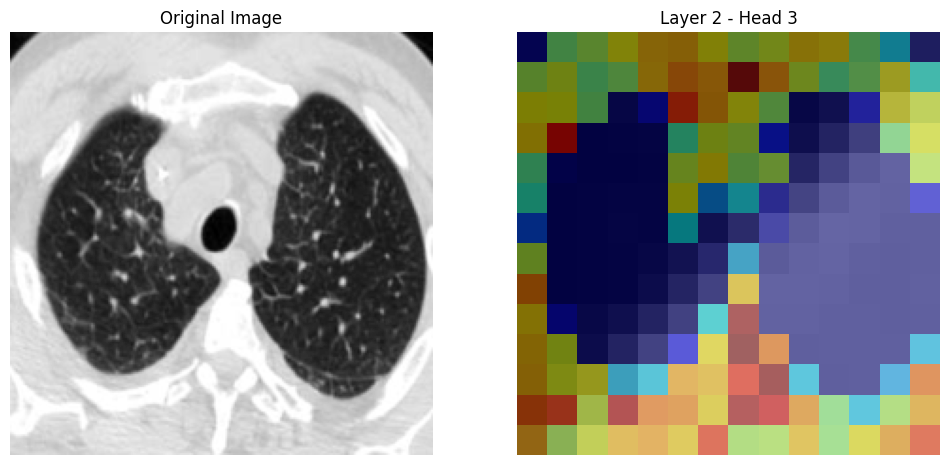

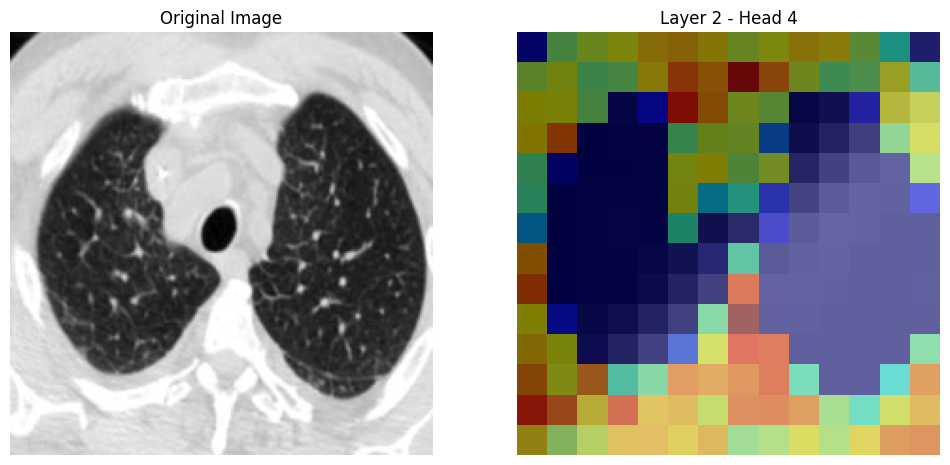

In [121]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(model, data_loader, num_heads=4):
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention_weights = model(inputs)

            # Выберите изображение
            img = inputs[0].cpu().numpy().transpose(1, 2, 0).squeeze()

            # Визуализация для каждого слоя и каждой головы
            for layer_idx, layer_attention in enumerate(attention_weights):
                layer_attention = layer_attention[0].cpu().numpy()  # (num_heads, seq_len, seq_len)
                
                for head_idx in range(num_heads):
                    attn = layer_attention[head_idx]  # (seq_len, seq_len)

                    # Усреднение по временной оси
                    attn_map = attn.mean(axis=0).reshape(14, 14)  # Преобразование в формат 14x14

                    # Визуализация изображения и карты внимания
                    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

                    axs[0].imshow(img, cmap='gray')
                    axs[0].set_title('Original Image')
                    axs[0].axis('off')

                    axs[1].imshow(img, cmap='gray')
                    axs[1].imshow(attn_map, cmap='jet', alpha=0.5)  # Среднее значение карты внимания
                    axs[1].set_title(f'Layer {layer_idx + 1} - Head {head_idx + 1}')
                    axs[1].axis('off')

                    plt.show()

            # Визуализируем только одно изображение
            break

# Визуализация карты внимания на валидационном наборе данных
visualize_attention(model, val_loader, num_heads=4)

# Оценка модели

Accuracy: 0.8169014084507042
Precision: 0.8267417201302769
Recall: 0.8169014084507042
MCC: 0.643631164647179


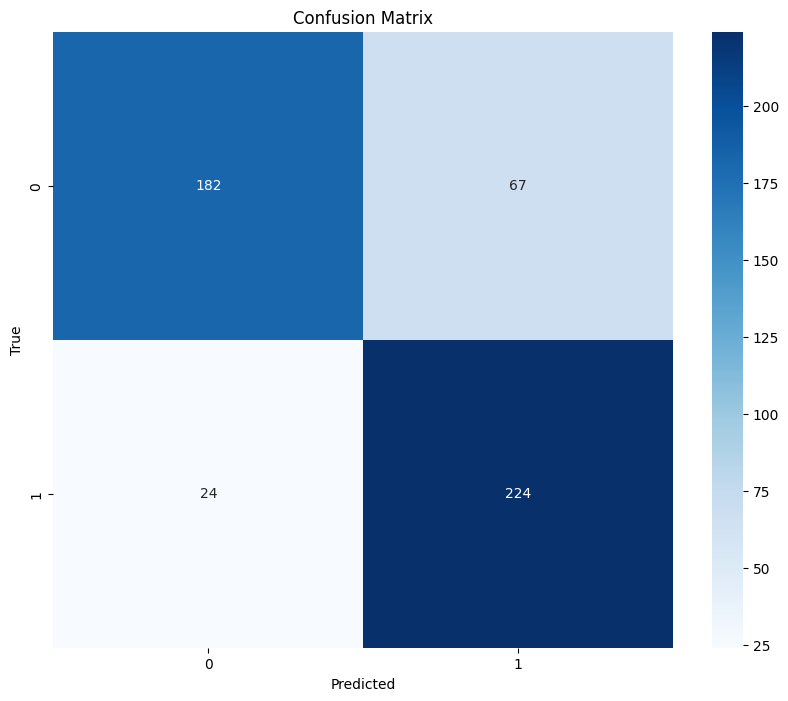

In [142]:
def evaluate_model(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    accuracy = np.mean(predicted_labels == true_labels)
    print("Accuracy:", accuracy)

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)

    recall = recall_score(true_labels, predicted_labels, average='weighted')
    print("Recall:", recall)

    mcc = matthews_corrcoef(true_labels, predicted_labels)
    print("MCC:", mcc)

    # Построить матрицу ошибок
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Оценить производительность модели на тестовом наборе данных
evaluate_model(model, val_loader)
